In [1]:
## Load the dataset and return the first few rows
import glob
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

Set up a regex to find the year from the filename

In [2]:
import re
year_match = re.compile('(\d{4})')

Couple of functions to transform the scoreline into useful data

In [3]:
def goals(result: str):
    '''Given a scoreline such as 6-1 returns home and away goals in a dict {home: 6, away: 1}'''
    nums = result.split('-')
    try:
        return {'home': int(nums[0]), 'away': int(nums[1])}
    except Exception:
        return {'home': -1, 'away': -1}

In [4]:
def outcome(result):
    '''Given a string of the result e.g. 6-1 categorise as either a no-score draw (1), score draw (2), home win (3) or away win (4)'''
    goals_result = goals(result)
    if goals_result['home'] == goals_result['away']:
        if goals_result['home'] == 0:
            return 1
        else:
            return 2
    elif goals_result['home'] > goals_result['away']:
        return 3
    else:
        return 4

Generate a list of available leagues from the folder names

In [5]:
league_list = glob.glob('/Users/dev/aicore/Football-predictor/Football-Dataset/*')
league_list = pd.DataFrame(league_list)
league_list.columns = ['folder']
league_list['name'] = league_list['folder'].apply(lambda x: x.split('/')[-1])
list(league_list['name'])

['championship',
 'eerste_divisie',
 'primeira_liga',
 'ligue_1',
 'segunda_division',
 '2_liga',
 'serie_a',
 'bundesliga',
 'primera_division',
 'ligue_2',
 'premier_league',
 'eredivisie',
 'segunda_liga',
 'serie_b']

Get all files in a particular folder and list their names

In [6]:
def get_files(folder):
    league_file_list = glob.glob(folder + '/*')
    league_file_list.sort()
    return league_file_list
league_list['files'] = league_list['folder'].apply(get_files)
league_list


folder              name  \
0   /Users/dev/aicore/Football-predictor/Football-...      championship   
1   /Users/dev/aicore/Football-predictor/Football-...    eerste_divisie   
2   /Users/dev/aicore/Football-predictor/Football-...     primeira_liga   
3   /Users/dev/aicore/Football-predictor/Football-...           ligue_1   
4   /Users/dev/aicore/Football-predictor/Football-...  segunda_division   
5   /Users/dev/aicore/Football-predictor/Football-...            2_liga   
6   /Users/dev/aicore/Football-predictor/Football-...           serie_a   
7   /Users/dev/aicore/Football-predictor/Football-...        bundesliga   
8   /Users/dev/aicore/Football-predictor/Football-...  primera_division   
9   /Users/dev/aicore/Football-predictor/Football-...           ligue_2   
10  /Users/dev/aicore/Football-predictor/Football-...    premier_league   
11  /Users/dev/aicore/Football-predictor/Football-...        eredivisie   
12  /Users/dev/aicore/Football-predictor/Football-...      segunda_liga   
13  /Users/dev/aicore/Football-predictor/Football-...           serie_b   

                                                files  
0   [/Users/dev/aicore/Football-predictor/Football...  
1   [/Users/dev/aicore/Football-predictor/Football...  
2   [/Users/dev/aicore/Football-predictor/Football...  
3   [/Users/dev/aicore/Football-predictor/Football...  
4   [/Users/dev/aicore/Football-predictor/Football...  
5   [/Users/dev/aicore/Football-predictor/Football...  
6   [/Users/dev/aicore/Football-predictor/Football...  
7   [/Users/dev/aicore/Football-predictor/Football...  
8   [/Users/dev/aicore/Football-predictor/Football...  
9   [/Users/dev/aicore/Football-predictor/Football...  
10  [/Users/dev/aicore/Football-predictor/Football...  
11  [/Users/dev/aicore/Football-predictor/Football...  
12  [/Users/dev/aicore/Football-predictor/Football...  
13  [/Users/dev/aicore/Football-predictor/Football...

Now run through the list of leagues (folders) and the files in them (in the files column), read in the data, and combine them together into dfs.

Results:

- `overall_team_counts` is a df showing the number of teams involved per league per season (unlikely to be consistent - and indeed not - EPL is a counterexample)
- `df_full` is the whole data of results across all leagues and seasons

In [7]:
overall_team_counts = pd.DataFrame()
df_league_lists = []
for index, league in league_list.iterrows():
    league_file_list = league['files']
    team_counts = {}
    df_list = []
    for file in league_file_list:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        year = year_match.findall(file)[0]
        if len(df.index) == 0:
            # print('No data for {}'.format(year))
            pass
        else:
            df_original = df.copy()
            df_list.append(df)
            team_counts[year] = len(df['home_team'].unique())
            # print('In {} there were {} teams'.format(year, len(df['Home_Team'].unique())))
    overall_team_counts = pd.concat([overall_team_counts, pd.Series(team_counts, name=league['name'])], axis=1)
    df_league_lists.append(pd.concat(df_list, ignore_index=True))
df_full = pd.concat(df_league_lists, ignore_index=True)
overall_team_counts.sort_index()
overall_team_counts = overall_team_counts.fillna(0).astype(int)

Use the functions defined earlier - `goals` and `outcome` - to transform the scoreline (as a string) into numerical data

In [8]:
df_full['goals'] = df_full['result'].apply(goals)
# in case we're repeating this operation
try:
    df_full = df_full.drop(['home','away'],axis=1) 
except Exception:
    pass
df_full = pd.concat([df_full, pd.json_normalize(df_full['goals'])], axis=1).drop('goals', axis=1)
# drop errors
df_full = df_full.drop(df_full[df_full.home == -1].index)
df_full['total_goals'] = df_full['home'] + df_full['away']
df_full['outcome'] = df_full['result'].apply(outcome)

In [9]:
df_full

home_team         away_team result  \
0       West Bromwich Albion  Sheffield United    0-3   
1               Swindon Town        Sunderland    0-2   
2                 Stoke City          West Ham    1-1   
3            Plymouth Argyle     Oxford United    2-0   
4                  Newcastle      Leeds United    5-2   
...                      ...               ...    ...   
146493                 Lecce              SPAL    1-2   
146494             Frosinone        Cittadella    1-1   
146495               Reggina          Vicenza     3-0   
146496               Venezia     Nuova Cosenza    3-0   
146497                Chievo              Pisa    2-0   

                                                     link  season  round  \
0       https://www.besoccer.com/match/west-bromwich/s...    1990      1   
1       https://www.besoccer.com/match/swindon-town/su...    1990      1   
2       https://www.besoccer.com/match/stoke-city/west...    1990      1   
3       https://www.besoccer.com/match/plymouth-argyle...    1990      1   
4       https://www.besoccer.com/match/newcastle-unite...    1990      1   
...                                                   ...     ...    ...   
146493  https://www.besoccer.com/match/lecce/spal-1907...    2021     33   
146494  https://www.besoccer.com/match/frosinone-calci...    2021     33   
146495  https://www.besoccer.com/match/reggina/vicenza...    2021     33   
146496  https://www.besoccer.com/match/venezia/nuova-c...    2021     33   
146497  https://www.besoccer.com/match/chievo/pisa-cal...    2021     33   

              league  home  away  total_goals  outcome  
0       championship     0     3            3        4  
1       championship     0     2            2        4  
2       championship     1     1            2        2  
3       championship     2     0            2        3  
4       championship     5     2            7        3  
...              ...   ...   ...          ...      ...  
146493       serie_b     1     2            3        4  
146494       serie_b     1     1            2        2  
146495       serie_b     3     0            3        3  
146496       serie_b     3     0            3        3  
146497       serie_b     2     0            2        3  

[146492 rows x 11 columns]

how can we extract a single league & season?

In [10]:
df = df_full.copy()

In [11]:
df[(df['season'] == 1990) & (df['league'] == 'championship')]

home_team            away_team result  \
0    West Bromwich Albion     Sheffield United    0-3   
1            Swindon Town           Sunderland    0-2   
2              Stoke City             West Ham    1-1   
3         Plymouth Argyle        Oxford United    2-0   
4               Newcastle         Leeds United    5-2   
..                    ...                  ...    ...   
547            Stoke City         Swindon Town    1-1   
548               Watford            Hull City    3-1   
549  West Bromwich Albion         Ipswich Town    1-3   
550              West Ham               Wolves    4-0   
551         Bradford City  Oldham Athletic AFC    1-1   

                                                  link  season  round  \
0    https://www.besoccer.com/match/west-bromwich/s...    1990      1   
1    https://www.besoccer.com/match/swindon-town/su...    1990      1   
2    https://www.besoccer.com/match/stoke-city/west...    1990      1   
3    https://www.besoccer.com/match/plymouth-argyle...    1990      1   
4    https://www.besoccer.com/match/newcastle-unite...    1990      1   
..                                                 ...     ...    ...   
547  https://www.besoccer.com/match/stoke-city/swin...    1990     10   
548  https://www.besoccer.com/match/watford-fc/hull...    1990     10   
549  https://www.besoccer.com/match/west-bromwich/i...    1990     10   
550  https://www.besoccer.com/match/west-ham-united...    1990     10   
551  https://www.besoccer.com/match/bradford-city/o...    1990     10   

           league  home  away  total_goals  outcome  
0    championship     0     3            3        4  
1    championship     0     2            2        4  
2    championship     1     1            2        2  
3    championship     2     0            2        3  
4    championship     5     2            7        3  
..            ...   ...   ...          ...      ...  
547  championship     1     1            2        2  
548  championship     3     1            4        3  
549  championship     1     3            4        4  
550  championship     4     0            4        3  
551  championship     1     1            2        2  

[552 rows x 11 columns]

## plot some graphs of single leagues across the seasons

<AxesSubplot:xlabel='season', ylabel='total_goals'>

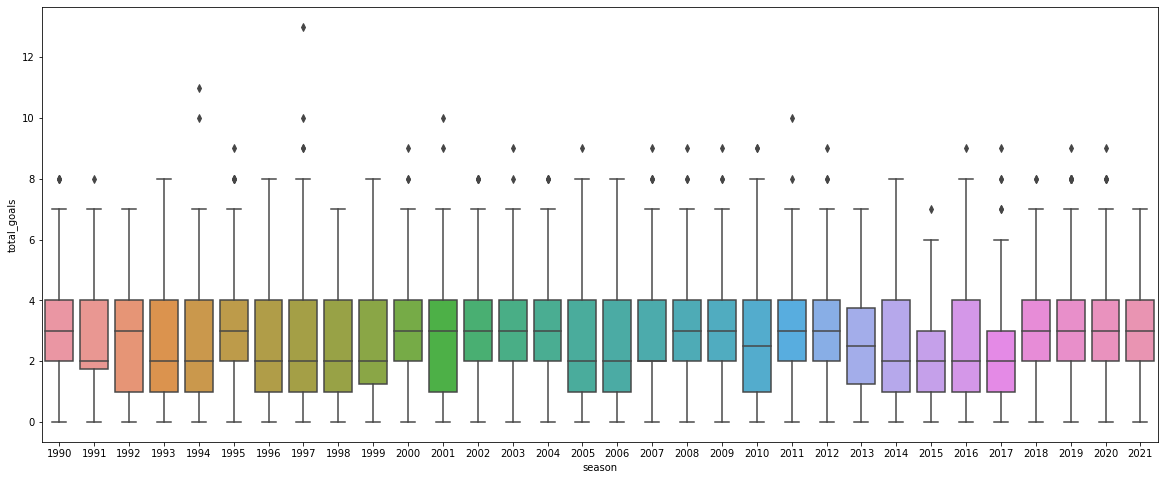

In [12]:
sns.boxplot(data=df[df['league']=='2_liga'], x='season', y='total_goals')

/Users/dev/miniforge3/envs/datascience/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


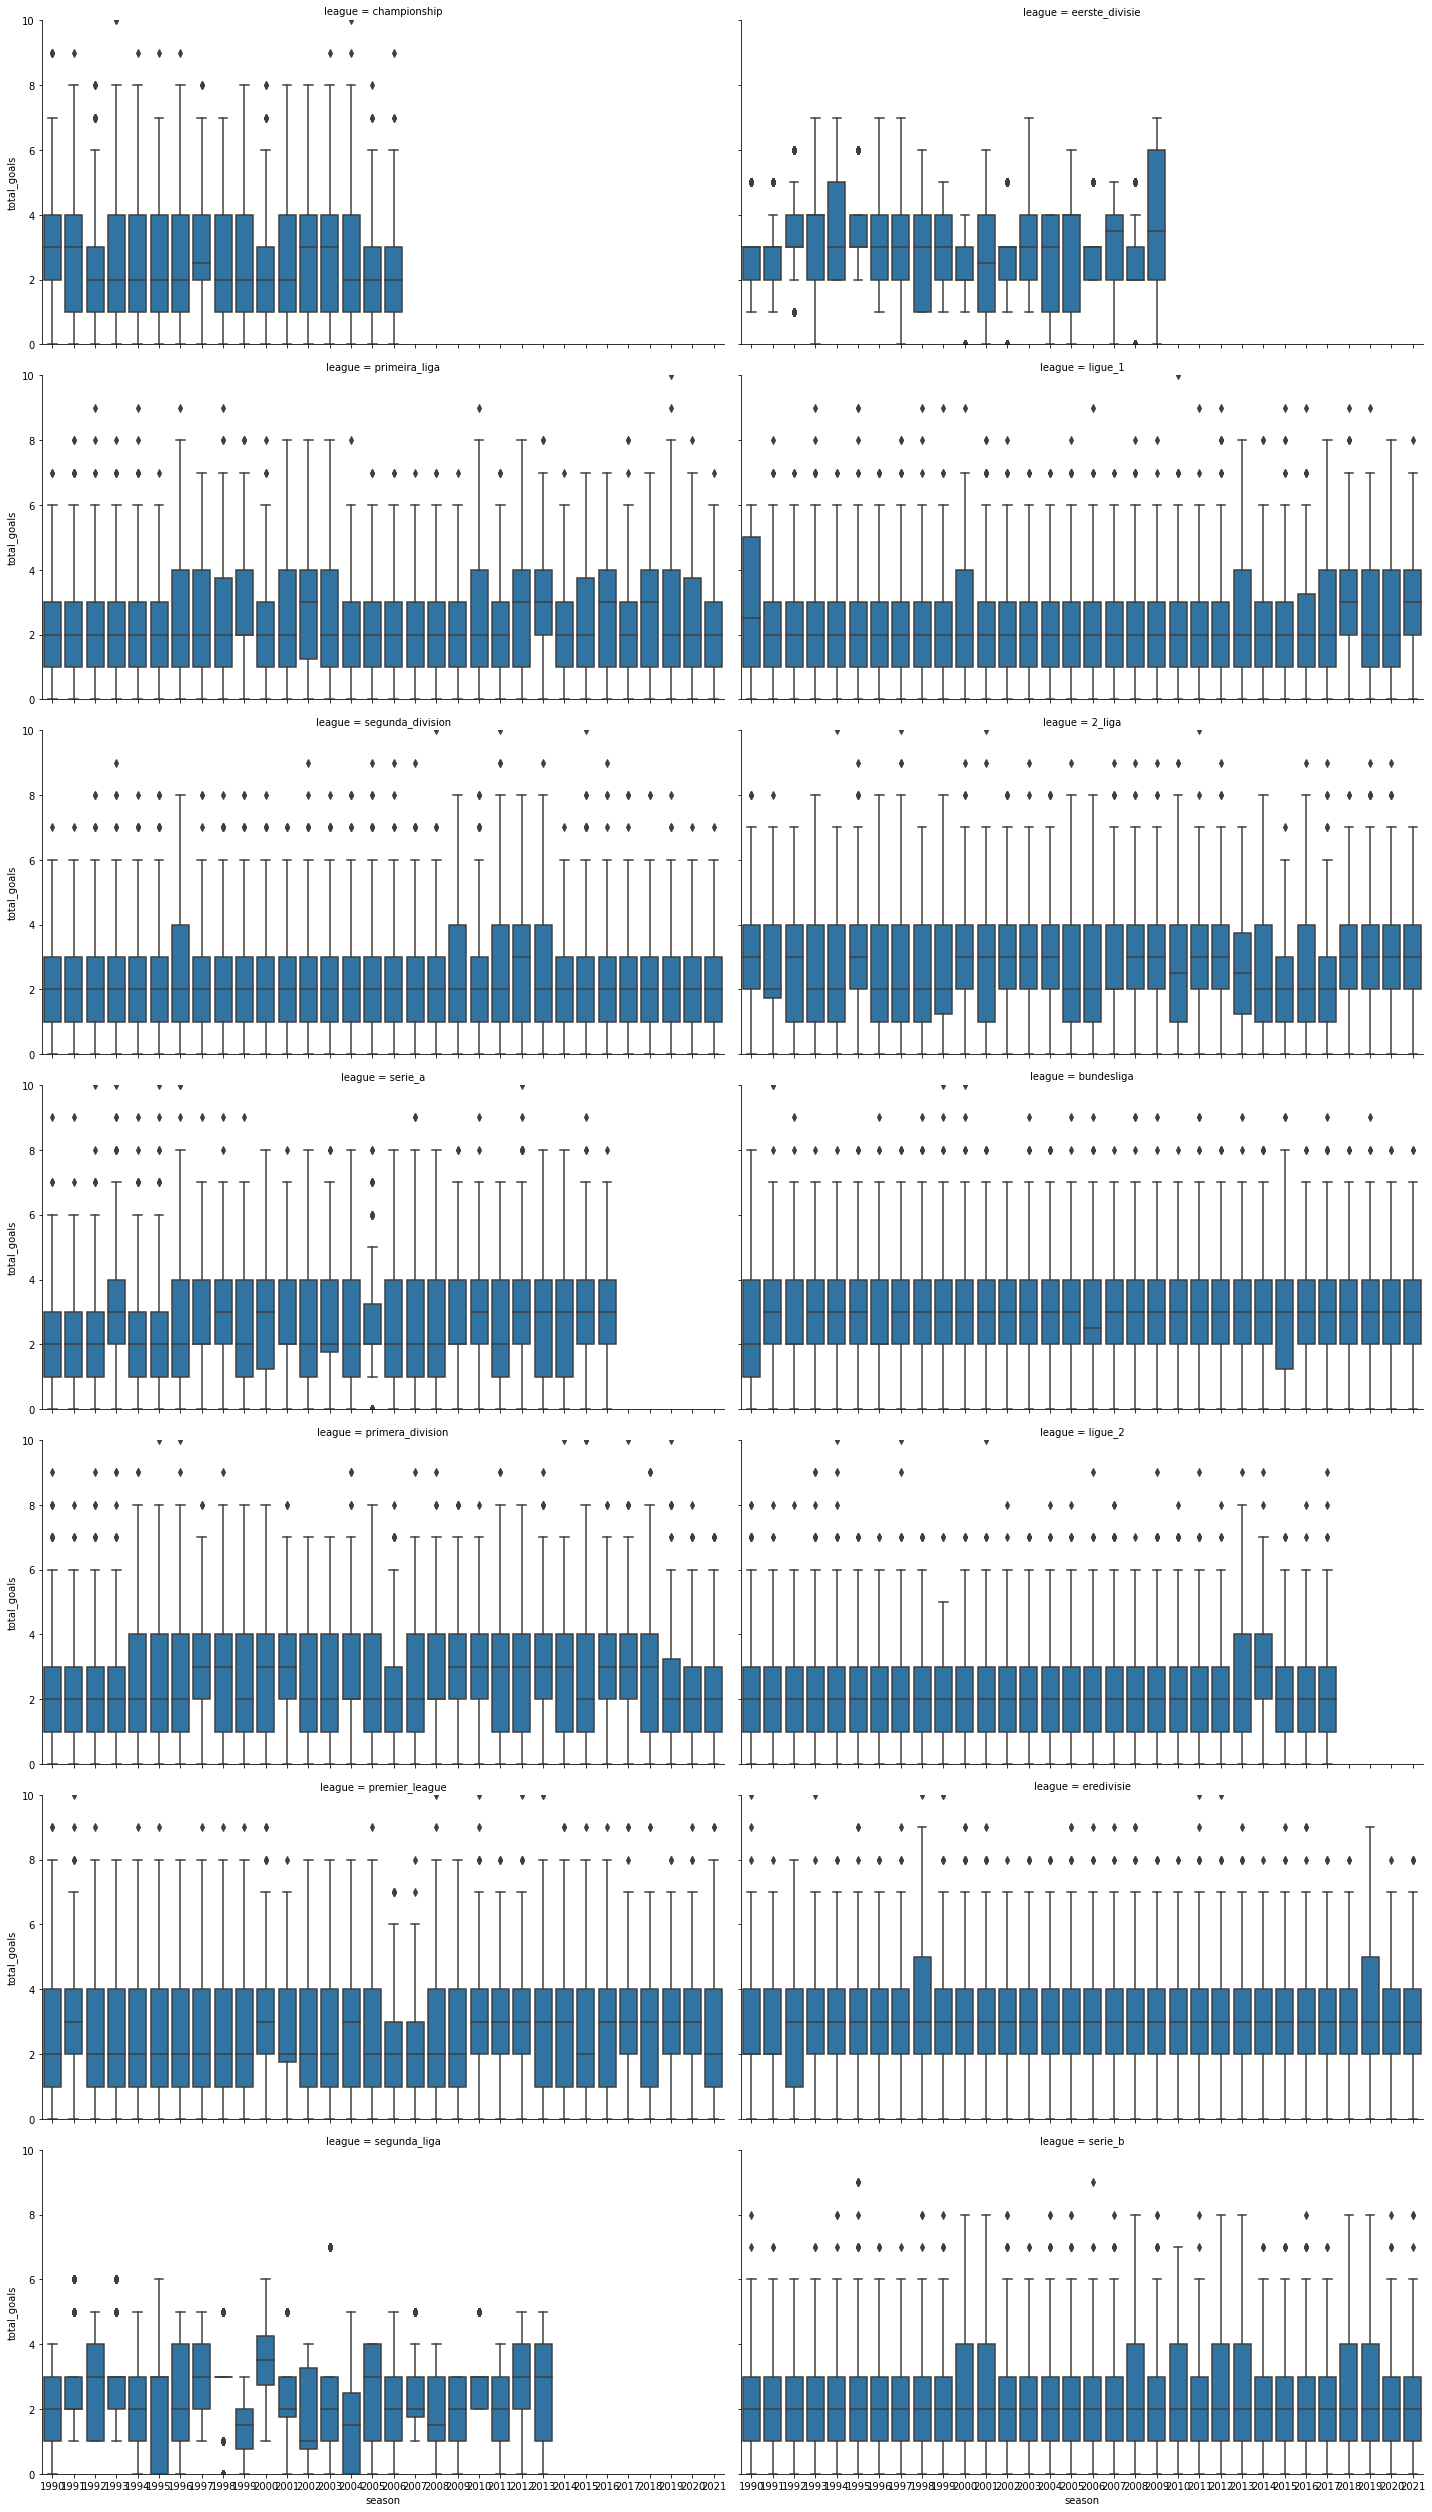

In [13]:
#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
g = sns.FacetGrid(df, col="league", col_wrap=2, height=5, aspect=2, ylim=(0, 10))
g.map(sns.boxplot, 'season', 'total_goals')

### Experiment with a stacked bar chart of different outcomes across the seasons

In [14]:
outcome_groups = df.groupby(['league','season','outcome'],as_index=False).size().set_index('season')
outcome_groups

league  outcome  size
season                        
1990     2_liga        1    31
1990     2_liga        2    84
1990     2_liga        3   188
1990     2_liga        4    77
1991     2_liga        1    40
...         ...      ...   ...
2020    serie_b        4   108
2021    serie_b        1    37
2021    serie_b        2    83
2021    serie_b        3   116
2021    serie_b        4    92

[1591 rows x 3 columns]

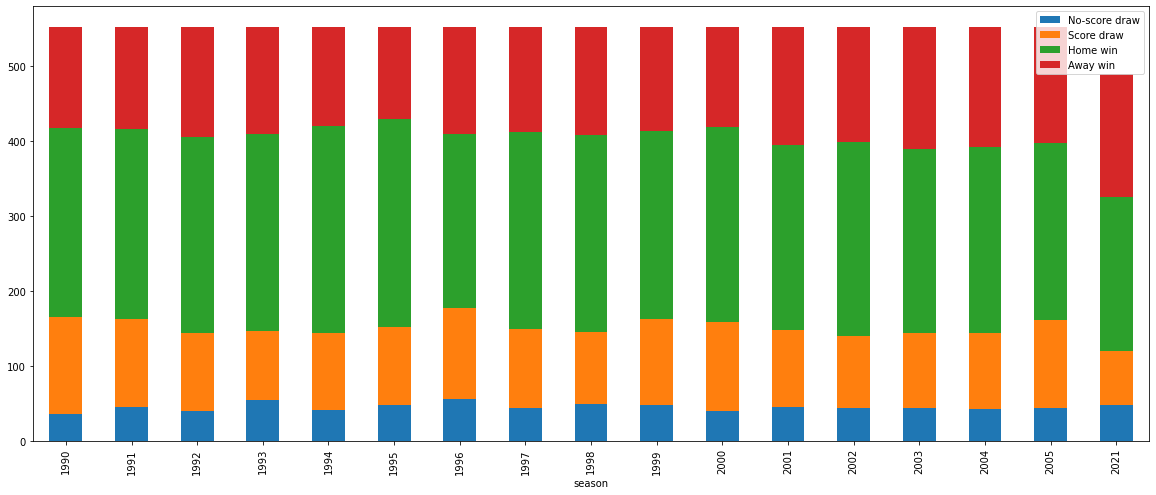

In [15]:
outcomes_per_season = outcome_groups[outcome_groups['league']=='championship'].pivot(columns='outcome')['size']
outcomes_per_season.plot(kind='bar', stacked=True)
plt.legend(['No-score draw','Score draw','Home win','Away win'])

## Now ... can we create a matrix of these?

In [16]:
len(list(league_list['name']))

14

## Trying plotly ?

This isn't working at all right now - but I'd like to debug it later so leaving it in situ for now

In [17]:
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go

In [18]:
from plotly.subplots import make_subplots

# programming_languages_by_age.index
fig = make_subplots(5, 3, subplot_titles=list(league_list['name']))
for i, league_name in enumerate(list(league_list['name'])):
    row = (i // 3) + 1
    col = (i % 3) + 1
    fig.add_trace(
        go.Bar(x=outcome_groups[outcome_groups['league']==league_name].pivot(columns='outcome').index,
            y=outcome_groups[outcome_groups['league']==league_name].pivot(columns='outcome')['size']),
        row=row, col=col
    )
fig.update_layout(showlegend=False, height=1000, title="Outcomes over the season in different leagues")
fig.update_yaxes(tickformat="%")
fig.show()

## Let's try pyplot instead

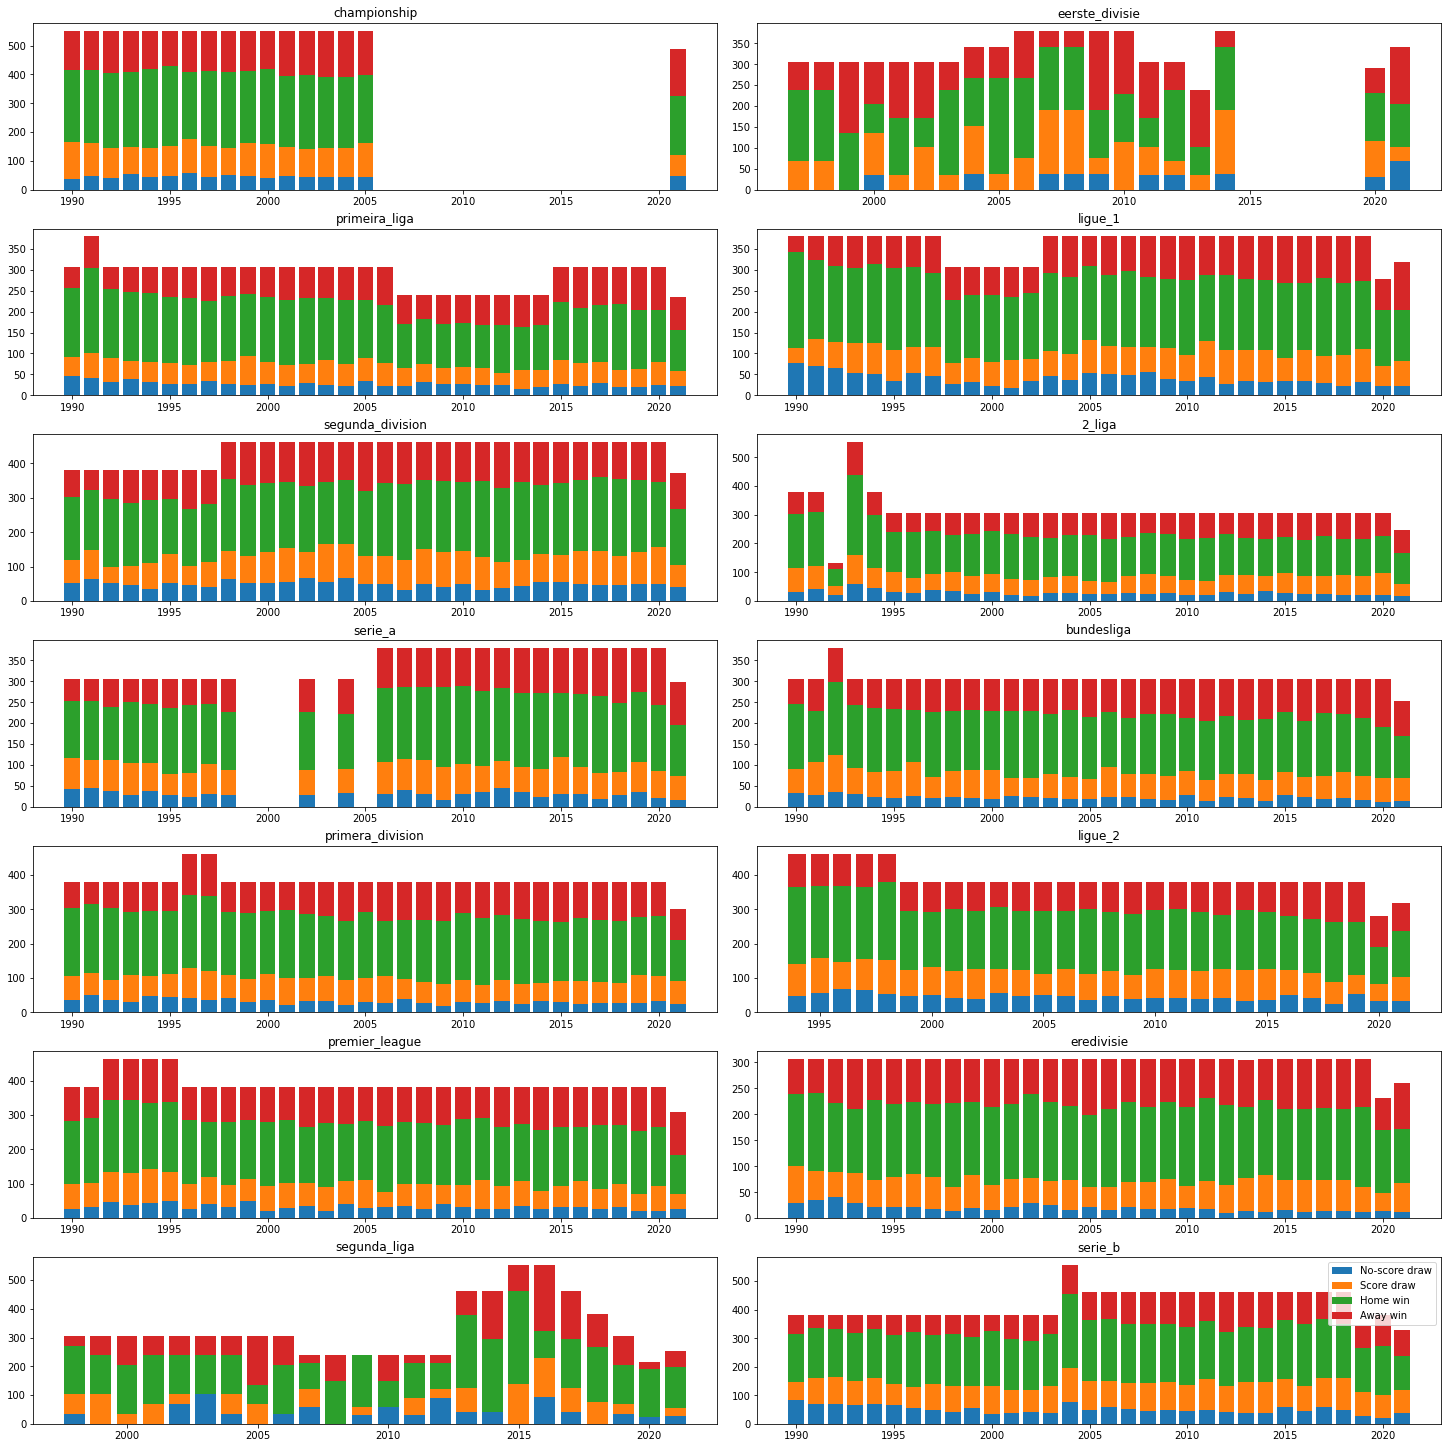

In [19]:
fig, ax = plt.subplots(7,2, constrained_layout=True, figsize=(20,20))
for i, league_name in enumerate(list(league_list['name'])):
    this_ax = ax[(i//2), i%2]
    outcomes_per_season_this_league = outcome_groups[outcome_groups['league']==league_name].pivot(columns='outcome')['size'].fillna(0)
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[1])
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[2], bottom=outcomes_per_season_this_league[1])
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[3], bottom=outcomes_per_season_this_league[2]+outcomes_per_season_this_league[1])
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[4], bottom=outcomes_per_season_this_league[3]+outcomes_per_season_this_league[2]+outcomes_per_season_this_league[1])
    this_ax.set_title(league_name)
    plt.legend(['No-score draw','Score draw','Home win','Away win'])

In [20]:
# good to see how facet work in plotly express but the box plots here aren't much use to me
fig = px.box(df, x='season', y='total_goals', facet_col='league', facet_col_wrap=2)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    width=1000,height=1000
)

## try some overview stats

In [21]:
lg = df[df['league']=='eerste_divisie']
lg

home_team        away_team result  \
9321       BV Veendam         Den Bosch    1-0   
9322    MVV Maastricht        Excelsior    3-0   
9323         Dordrecht       SC Telstar    2-1   
9324      HFC Haarlem      FC Eindhoven    1-2   
9325   Go Ahead Eagles   RBC Roosendaal    2-0   
...                ...              ...    ...   
15902       SC Telstar      FC Volendam    2-2   
15903        Jong Ajax          Roda JC    0-4   
15904        Dordrecht  Go Ahead Eagles    0-0   
15905      Almere City   MVV Maastricht    0-0   
15906    De Graafschap        Den Bosch    4-2   

                                                    link  season  round  \
9321   https://www.besoccer.com/match/veendam/fc-den-...    1997      1   
9322   https://www.besoccer.com/match/mvv/excelsior/1...    1997      1   
9323   https://www.besoccer.com/match/fc-dordrecht/st...    1997      1   
9324   https://www.besoccer.com/match/haarlem/fc-eind...    1997      1   
9325   https://www.besoccer.com/match/go-ahead-eagles...    1997      1   
...                                                  ...     ...    ...   
15902  https://www.besoccer.com/match/stormvogels-tel...    2021     34   
15903  https://www.besoccer.com/match/jong-ajax/roda-...    2021     34   
15904  https://www.besoccer.com/match/fc-dordrecht/go...    2021     34   
15905  https://www.besoccer.com/match/almere-city/mvv...    2021     34   
15906  https://www.besoccer.com/match/graafschap/fc-d...    2021     34   

               league  home  away  total_goals  outcome  
9321   eerste_divisie     1     0            1        3  
9322   eerste_divisie     3     0            3        3  
9323   eerste_divisie     2     1            3        3  
9324   eerste_divisie     1     2            3        4  
9325   eerste_divisie     2     0            2        3  
...               ...   ...   ...          ...      ...  
15902  eerste_divisie     2     2            4        2  
15903  eerste_divisie     0     4            4        4  
15904  eerste_divisie     0     0            0        1  
15905  eerste_divisie     0     0            0        1  
15906  eerste_divisie     4     2            6        3  

[6586 rows x 11 columns]

In [22]:
outcome_groups[outcome_groups['league']=='eerste_divisie'].pivot(columns='outcome')['size'].fillna(0)

outcome     1      2      3      4
season                            
1997      0.0   68.0  170.0   68.0
1998      0.0   68.0  170.0   68.0
1999      0.0    0.0  136.0  170.0
2000     34.0  102.0   68.0  102.0
2001      0.0   34.0  136.0  136.0
2002      0.0  102.0   68.0  136.0
2003      0.0   34.0  204.0   68.0
2004     38.0  114.0  114.0   76.0
2005      0.0   38.0  228.0   76.0
2006      0.0   76.0  190.0  114.0
2007     38.0  152.0  152.0   38.0
2008     38.0  152.0  152.0   38.0
2009     38.0   38.0  114.0  190.0
2010      0.0  114.0  114.0  152.0
2011     34.0   68.0   68.0  136.0
2012     34.0   34.0  170.0   68.0
2013      0.0   34.0   68.0  136.0
2014     38.0  152.0  152.0   38.0
2020     29.0   87.0  116.0   58.0
2021     68.0   34.0  102.0  136.0

<AxesSubplot:xlabel='outcome', ylabel='count'>

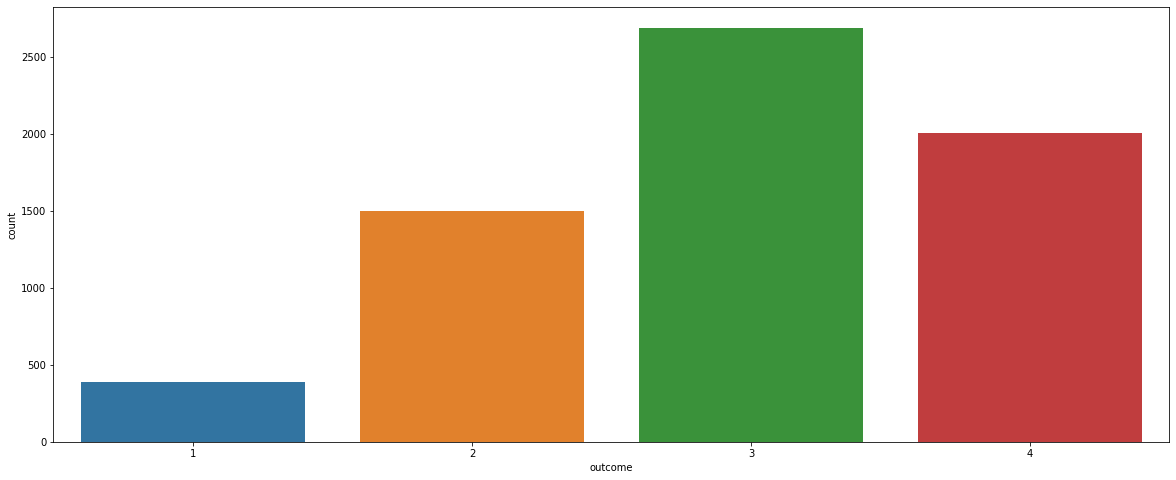

In [23]:
num_var = lg.select_dtypes(include="number")
sns.countplot(data=num_var, x='outcome')

# Stats per league

In [24]:
league_list['team_count'] = 0
for i, league_name in enumerate(list(league_list['name'])):
    lg = df[df['league']==league_name]
    seasons = list(set().union(list(lg.season.unique())))
    league_list['team_count'][i] = max([len(set(df[(df['league']==league_name) & (df['season']==season)]['home_team'])) for season in seasons])
league_list

/var/folders/3m/mch0swq10qd743jg357mbd7h0000gp/T/ipykernel_54563/11890680.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



folder              name  \
0   /Users/dev/aicore/Football-predictor/Football-...      championship   
1   /Users/dev/aicore/Football-predictor/Football-...    eerste_divisie   
2   /Users/dev/aicore/Football-predictor/Football-...     primeira_liga   
3   /Users/dev/aicore/Football-predictor/Football-...           ligue_1   
4   /Users/dev/aicore/Football-predictor/Football-...  segunda_division   
5   /Users/dev/aicore/Football-predictor/Football-...            2_liga   
6   /Users/dev/aicore/Football-predictor/Football-...           serie_a   
7   /Users/dev/aicore/Football-predictor/Football-...        bundesliga   
8   /Users/dev/aicore/Football-predictor/Football-...  primera_division   
9   /Users/dev/aicore/Football-predictor/Football-...           ligue_2   
10  /Users/dev/aicore/Football-predictor/Football-...    premier_league   
11  /Users/dev/aicore/Football-predictor/Football-...        eredivisie   
12  /Users/dev/aicore/Football-predictor/Football-...      segunda_liga   
13  /Users/dev/aicore/Football-predictor/Football-...           serie_b   

                                                files  team_count  
0   [/Users/dev/aicore/Football-predictor/Football...          24  
1   [/Users/dev/aicore/Football-predictor/Football...          10  
2   [/Users/dev/aicore/Football-predictor/Football...          20  
3   [/Users/dev/aicore/Football-predictor/Football...          20  
4   [/Users/dev/aicore/Football-predictor/Football...          22  
5   [/Users/dev/aicore/Football-predictor/Football...          24  
6   [/Users/dev/aicore/Football-predictor/Football...          20  
7   [/Users/dev/aicore/Football-predictor/Football...          20  
8   [/Users/dev/aicore/Football-predictor/Football...          22  
9   [/Users/dev/aicore/Football-predictor/Football...          22  
10  [/Users/dev/aicore/Football-predictor/Football...          22  
11  [/Users/dev/aicore/Football-predictor/Football...          18  
12  [/Users/dev/aicore/Football-predictor/Football...          12  
13  [/Users/dev/aicore/Football-predictor/Football...          24

## Aggregate across all leagues (per season)

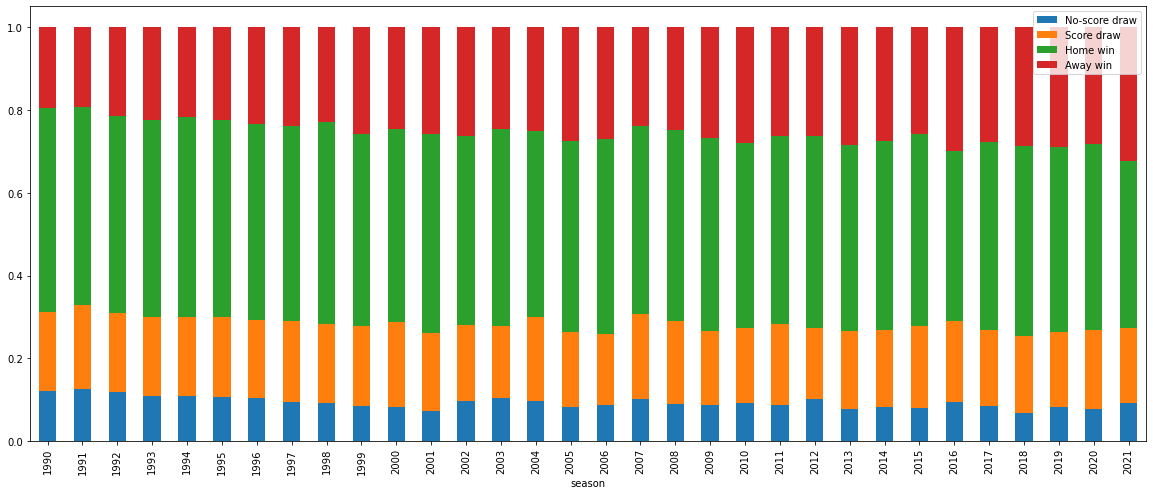

In [25]:
all_leagues_2 = df.groupby(['season','outcome'],as_index=False).size().set_index('season').pivot(columns=['outcome'])
# see https://stackoverflow.com/questions/35678874/normalize-rows-of-pandas-data-frame-by-their-sums
all_leagues_2 = all_leagues_2.div(all_leagues_2.sum(axis=1), axis=0)
all_leagues_2.plot(kind='bar', stacked=True)
plt.legend(['No-score draw','Score draw','Home win','Away win'])

## Additional datasets - join them on

## first: match info

In [26]:
match_df = pd.read_csv('additional-data/Match_Info.csv')
match_df.columns = match_df.columns.str.lower()
# match_df.info()
match_df['referee'] = match_df['referee'].str.strip().str.replace('Referee: ','')
match_df['date_dt'] = pd.to_datetime(match_df['date_new'])
match_df['link_parts'] = match_df['link'].str.split('/')
match_df['home_team'] = match_df.apply(lambda row: row['link_parts'][-3], axis=1)
match_df['away_team'] = match_df.apply(lambda row: row['link_parts'][-2], axis=1)
match_df['season'] = match_df.apply(lambda row: row['link_parts'][-1], axis=1)
match_df = match_df.drop(['date_new'], axis=1)
match_df

link  \
0             /match/saarbrucken/stuttgarter-kickers/1990   
1                    /match/sc-freiburg/unterhaching/1990   
2                        /match/vfl-osnabruck/meppen/1990   
3                  /match/rot-weiss-essen/schalke-04/1990   
4               /match/alemannia-aachen/msv-duisburg/1990   
...                                                   ...   
143343             /match/sunderland-afc/oxford-city/1999   
143344                     /match/fc-gueugnon/bastia/1994   
143345          /match/tranmere-rovers/wolverhampton/1999   
143346                       /match/sochaux/guingamp/2021   
143347  /match/huddersfield-town-fc/crystal-palace-fc/...   

                    referee  home_yellow  home_red  away_yellow  away_red  \
0         Hans-Jürgen Weber          0.0       0.0          3.0       0.0   
1               Kurt Wittke          1.0       0.0          0.0       0.0   
2            Werner Föckler          3.0       0.0          2.0       0.0   
3              Heinz Werner          2.0       0.0          2.0       0.0   
4       Hans-Peter Dellwing          1.0       0.0          1.0       0.0   
...                     ...          ...       ...          ...       ...   
143343        Anthony Leake          1.0       0.0          0.0       0.0   
143344      Jacques Poulain          0.0       0.0          0.0       0.0   
143345          Kevin Lynch          2.0       0.0          1.0       0.0   
143346             Baert A.          0.0       0.0          2.0       0.0   
143347          George Cain          1.0       0.0          1.0       0.0   

                   date_dt                                         link_parts  \
0      1989-07-29 15:00:00  [, match, saarbrucken, stuttgarter-kickers, 1990]   
1      1989-07-29 15:00:00         [, match, sc-freiburg, unterhaching, 1990]   
2      1989-07-29 15:00:00             [, match, vfl-osnabruck, meppen, 1990]   
3      1989-07-29 15:00:00       [, match, rot-weiss-essen, schalke-04, 1990]   
4      1989-07-29 15:00:00    [, match, alemannia-aachen, msv-duisburg, 1990]   
...                    ...                                                ...   
143343 1998-09-19 00:00:00       [, match, sunderland-afc, oxford-city, 1999]   
143344 1994-05-17 00:00:00               [, match, fc-gueugnon, bastia, 1994]   
143345 1999-01-08 00:00:00    [, match, tranmere-rovers, wolverhampton, 1999]   
143346 2021-02-27 19:00:00                 [, match, sochaux, guingamp, 2021]   
143347 1998-12-05 00:00:00  [, match, huddersfield-town-fc, crystal-palace...   

                   home_team            away_team season  
0                saarbrucken  stuttgarter-kickers   1990  
1                sc-freiburg         unterhaching   1990  
2              vfl-osnabruck               meppen   1990  
3            rot-weiss-essen           schalke-04   1990  
4           alemannia-aachen         msv-duisburg   1990  
...                      ...                  ...    ...  
143343        sunderland-afc          oxford-city   1999  
143344           fc-gueugnon               bastia   1994  
143345       tranmere-rovers        wolverhampton   1999  
143346               sochaux             guingamp   2021  
143347  huddersfield-town-fc    crystal-palace-fc   1999  

[143348 rows x 11 columns]

Let's look at what the team names are and see where they're not matching

In [27]:
print(df[df['league']=='premier_league']['home_team'].unique())
[ht for ht in match_df['home_team'].unique() if 'manchester' in ht or 'brighton' in ht or 'newc' in ht]

['Charlton Athletic' 'Tottenham Hotspur' 'Southampton'
 'Sheffield Wednesday' 'Queens Park Rangers' 'Nottingham Forest'
 'Man. Utd' 'Liverpool' 'Coventry City' 'Wimbledon FC' 'Arsenal'
 'Millwall' 'Luton Town' 'Everton' 'Crystal Palace' 'Chelsea'
 'Aston Villa' 'Derby County' 'Man. City' 'Norwich City'
 'Sheffield United' 'Leeds United' 'Sunderland' 'West Ham' 'Notts County'
 'Oldham Athletic AFC' 'Ipswich Town' 'Blackburn Rovers' 'Middlesbrough'
 'Newcastle' 'Swindon Town' 'Leicester' 'Bolton Wanderers' 'Barnsley'
 'Watford' 'Bradford City' 'Fulham' 'Birmingham City'
 'West Bromwich Albion' 'Portsmouth' 'Wolves' 'Wigan Athletic' 'Reading'
 'Hull City' 'Stoke City' 'Burnley' 'Blackpool' 'Swansea City'
 'Cardiff City' 'AFC Bournemouth' 'Brighton & Hove Albion'
 'Huddersfield Town']


['brighton-amp-hov',
 'newcastle-united-fc',
 'manchester-city-fc',
 'manchester-united-fc']

So let's try a fuzzy match and create a kind of hash table between the two different team name sources. This first effort is OK-ish, but not great...

In [28]:
import difflib
df_teams = df['home_team'].unique()
match_teams = match_df['home_team'].unique()


In [29]:
import pprint
matched_teams = [(d,(difflib.get_close_matches(d,match_teams,n=1,cutoff=0.4)[:1] or [None])[0]) for d in df_teams]
pprint.pprint(matched_teams)

[('West Bromwich Albion', 'west-bromwich'),
 ('Swindon Town', 'swindon-town'),
 ('Stoke City', 'stoke-city'),
 ('Plymouth Argyle', 'plymouth-argyle'),
 ('Newcastle', 'newcastle-united-fc'),
 ('Middlesbrough', 'middlesbrough-fc'),
 ('Ipswich Town', 'ipswich-town-fc'),
 ('Hull City', 'hull-city'),
 ('Brighton & Hove Albion', 'brighton-amp-hov'),
 ('Bradford City', 'bradford-city'),
 ('Blackburn Rovers', 'blackburn-rovers-fc'),
 ('Watford', 'watford-fc'),
 ('Sunderland', 'sunderland-afc'),
 ('Oldham Athletic AFC', 'oldham-athletic-afc'),
 ('AFC Bournemouth', 'afc-bournemouth'),
 ('Leeds United', 'leeds-united-afc'),
 ('West Ham', 'red-star'),
 ('Leicester', 'leicester-city-fc'),
 ('Wolves', 'alaves'),
 ('Sheffield United', 'sheffield-united'),
 ('Portsmouth', 'portsmouth'),
 ('Port Vale', 'port-vale'),
 ('Oxford United', 'oxford-united'),
 ('Barnsley', 'barnsley-fc'),
 ('Bristol City', 'bristol-city-fc'),
 ('Charlton Athletic', 'charlton-athletic-fc'),
 ('Millwall', 'millwall-fc'),
 ('Bri

Instead let's try Levenshtein. see https://www.datacamp.com/community/tutorials/fuzzy-string-python

In [30]:
from fuzzywuzzy import process
# needs a tweak for Manchester to give a helping hand on those two teams
matched_teams = [(d,(process.extractOne(d.replace('Man.','Manchester'), match_teams))[0]) for d in df_teams]

In [31]:
matched_teams

[('West Bromwich Albion', 'west-bromwich'),
 ('Swindon Town', 'swindon-town'),
 ('Stoke City', 'stoke-city'),
 ('Plymouth Argyle', 'plymouth-argyle'),
 ('Newcastle', 'newcastle-united-fc'),
 ('Middlesbrough', 'middlesbrough-fc'),
 ('Ipswich Town', 'ipswich-town-fc'),
 ('Hull City', 'hull-city'),
 ('Brighton & Hove Albion', 'brighton-amp-hov'),
 ('Bradford City', 'bradford-city'),
 ('Blackburn Rovers', 'blackburn-rovers-fc'),
 ('Watford', 'watford-fc'),
 ('Sunderland', 'sunderland-afc'),
 ('Oldham Athletic AFC', 'oldham-athletic-afc'),
 ('AFC Bournemouth', 'afc-bournemouth'),
 ('Leeds United', 'leeds-united-afc'),
 ('West Ham', 'west-ham-united'),
 ('Leicester', 'leicester-city-fc'),
 ('Wolves', 'wolverhampton'),
 ('Sheffield United', 'sheffield-united'),
 ('Portsmouth', 'portsmouth'),
 ('Port Vale', 'port-vale'),
 ('Oxford United', 'oxford-united'),
 ('Barnsley', 'barnsley-fc'),
 ('Bristol City', 'bristol-city-fc'),
 ('Charlton Athletic', 'charlton-athletic-fc'),
 ('Millwall', 'millwal

In [32]:
# check up on a problematic item from later on
[t for t in matched_teams if t[0]=='Terassa']

[]

In [33]:
def team_name_for_link(t):
    matches = [x[1] for x in matched_teams if x[0] == t]
    return (matches if len(matches)>0 else [''])[0]

In [34]:
df['link'] = df.apply(lambda row: '/'.join(['','match',team_name_for_link(row['home_team']),team_name_for_link(row['away_team']),str(row['season'])]).strip().lower().replace(' ','-'), axis=1)
df

home_team         away_team result  \
0       West Bromwich Albion  Sheffield United    0-3   
1               Swindon Town        Sunderland    0-2   
2                 Stoke City          West Ham    1-1   
3            Plymouth Argyle     Oxford United    2-0   
4                  Newcastle      Leeds United    5-2   
...                      ...               ...    ...   
146493                 Lecce              SPAL    1-2   
146494             Frosinone        Cittadella    1-1   
146495               Reggina          Vicenza     3-0   
146496               Venezia     Nuova Cosenza    3-0   
146497                Chievo              Pisa    2-0   

                                                    link  season  round  \
0             /match/west-bromwich/sheffield-united/1990    1990      1   
1                /match/swindon-town/sunderland-afc/1990    1990      1   
2                 /match/stoke-city/west-ham-united/1990    1990      1   
3              /match/plymouth-argyle/oxford-united/1990    1990      1   
4       /match/newcastle-united-fc/leeds-united-afc/1990    1990      1   
...                                                  ...     ...    ...   
146493                       /match/lecce/spal-1907/2021    2021     33   
146494        /match/frosinone-calcio/as-cittadella/2021    2021     33   
146495                /match/reggina/vicenza-calcio/2021    2021     33   
146496                 /match/venezia/nuova-cosenza/2021    2021     33   
146497                    /match/chievo/pisa-calcio/2021    2021     33   

              league  home  away  total_goals  outcome  
0       championship     0     3            3        4  
1       championship     0     2            2        4  
2       championship     1     1            2        2  
3       championship     2     0            2        3  
4       championship     5     2            7        3  
...              ...   ...   ...          ...      ...  
146493       serie_b     1     2            3        4  
146494       serie_b     1     1            2        2  
146495       serie_b     3     0            3        3  
146496       serie_b     3     0            3        3  
146497       serie_b     2     0            2        3  

[146492 rows x 11 columns]

In [35]:
# duplicates?
print(df['link'].duplicated().value_counts())
print(df[['home_team','away_team','season','league']].duplicated().value_counts())

False    130890
True      15602
Name: link, dtype: int64
False    132103
True      14389
dtype: int64


In [36]:
df.drop_duplicates(subset=['home_team','away_team','season','league'], inplace=True)

In [37]:
df2 = pd.merge(match_df, df, how="inner", on='link')
df2

link  \
0             /match/saarbrucken/stuttgarter-kickers/1990   
1                    /match/sc-freiburg/unterhaching/1990   
2                        /match/vfl-osnabruck/meppen/1990   
3                  /match/rot-weiss-essen/schalke-04/1990   
4               /match/alemannia-aachen/msv-duisburg/1990   
...                                                   ...   
114109             /match/sunderland-afc/oxford-city/1999   
114110                     /match/fc-gueugnon/bastia/1994   
114111          /match/tranmere-rovers/wolverhampton/1999   
114112                       /match/sochaux/guingamp/2021   
114113  /match/huddersfield-town-fc/crystal-palace-fc/...   

                    referee  home_yellow  home_red  away_yellow  away_red  \
0         Hans-Jürgen Weber          0.0       0.0          3.0       0.0   
1               Kurt Wittke          1.0       0.0          0.0       0.0   
2            Werner Föckler          3.0       0.0          2.0       0.0   
3              Heinz Werner          2.0       0.0          2.0       0.0   
4       Hans-Peter Dellwing          1.0       0.0          1.0       0.0   
...                     ...          ...       ...          ...       ...   
114109        Anthony Leake          1.0       0.0          0.0       0.0   
114110      Jacques Poulain          0.0       0.0          0.0       0.0   
114111          Kevin Lynch          2.0       0.0          1.0       0.0   
114112             Baert A.          0.0       0.0          2.0       0.0   
114113          George Cain          1.0       0.0          1.0       0.0   

                   date_dt                                         link_parts  \
0      1989-07-29 15:00:00  [, match, saarbrucken, stuttgarter-kickers, 1990]   
1      1989-07-29 15:00:00         [, match, sc-freiburg, unterhaching, 1990]   
2      1989-07-29 15:00:00             [, match, vfl-osnabruck, meppen, 1990]   
3      1989-07-29 15:00:00       [, match, rot-weiss-essen, schalke-04, 1990]   
4      1989-07-29 15:00:00    [, match, alemannia-aachen, msv-duisburg, 1990]   
...                    ...                                                ...   
114109 1998-09-19 00:00:00       [, match, sunderland-afc, oxford-city, 1999]   
114110 1994-05-17 00:00:00               [, match, fc-gueugnon, bastia, 1994]   
114111 1999-01-08 00:00:00    [, match, tranmere-rovers, wolverhampton, 1999]   
114112 2021-02-27 19:00:00                 [, match, sochaux, guingamp, 2021]   
114113 1998-12-05 00:00:00  [, match, huddersfield-town-fc, crystal-palace...   

                 home_team_x          away_team_x season_x        home_team_y  \
0                saarbrucken  stuttgarter-kickers     1990        Saarbrücken   
1                sc-freiburg         unterhaching     1990        SC Freiburg   
2              vfl-osnabruck               meppen     1990      VfL Osnabrück   
3            rot-weiss-essen           schalke-04     1990           RW Essen   
4           alemannia-aachen         msv-duisburg     1990   Alemannia Aachen   
...                      ...                  ...      ...                ...   
114109        sunderland-afc          oxford-city     1999         Sunderland   
114110           fc-gueugnon               bastia     1994        FC Gueugnon   
114111       tranmere-rovers        wolverhampton     1999    Tranmere Rovers   
114112               sochaux             guingamp     2021            Sochaux   
114113  huddersfield-town-fc    crystal-palace-fc     1999  Huddersfield Town   

                away_team_y result  season_y  round        league  home  away  \
0       Stuttgarter Kickers    1-0      1990      1        2_liga     1     0   
1              Unterhaching    2-3      1990      1        2_liga     2     3   
2                    Meppen    1-1      1990      1        2_liga     1     1   
3                Schalke 04    0-0      1990      1        2_liga     0     0   
4              MSV Duisburg    1-2      1990

## add team info

In [38]:
team_df = pd.read_csv('additional-data/Team_Info.csv')
team_df

Team                 City  Country  \
0    Wattenscheid 09  Bochum-Wattenscheid  Germany   
1         Hertha BSC               Berlín  Germany   
2       Unterhaching         Unterhaching  Germany   
3       Fortuna Köln              Cologne  Germany   
4       MSV Duisburg            Duisburgo  Germany   
..               ...                  ...      ...   
539           Latina               Latina    Italy   
540   Virtus Entella             Chiavari    Italy   
541    Nuova Cosenza              Cosenza    Italy   
542        Pordenone            Pordenone    Italy   
543       Bourges 18              Bourges   France   

                                Stadium Capacity              Pitch  
0                      Lohrheidestadion    16233            Natural  
1                 Olympiastadion Berlin    76065            Natural  
2                Sportpark Unterhaching    15053            Natural  
3                            Südstadion    14944            Natural  
4             Schauinsland-Reisen-Arena    31514            Natural  
..                                  ...      ...                ...  
539  Stadio Comunale Domenico Francioni     8000            Natural  
540            Stadio Comunale Chiavari     4154  Césped Artificial  
541                     Stadio San Vito    24209            Natural  
542                                 NaN     3089                NaN  
543                                 NaN   13,000                NaN  

[544 rows x 6 columns]

In [39]:
team_df.columns = team_df.columns.str.lower()
team_df['capacity'] = pd.to_numeric(team_df['capacity'].str.replace(',',''))
team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   team      544 non-null    object
 1   city      544 non-null    object
 2   country   544 non-null    object
 3   stadium   447 non-null    object
 4   capacity  544 non-null    int64 
 5   pitch     447 non-null    object
dtypes: int64(1), object(5)
memory usage: 25.6+ KB


In [ ]:
teams_from_team_data = set(team_df.team)
link_team_data = set(df2.home_team_x)
# originally I had this the other way round, which resulted in multiple matches
matched_teams_team_data = [(d,(process.extractOne(d.replace('Man.','Manchester'), teams_from_team_data))[0]) for d in link_team_data]

In [41]:
# should be only a single match ... working better now
[t for t in matched_teams_team_data if t[0]=='crystal-palace-fc']

[('crystal-palace-fc', 'Crystal Palace')]

In [42]:
def team_name_for_link_team_data(t):
    matches = [x[0] for x in matched_teams_team_data if x[1] == t]
    return (matches if len(matches)>0 else [''])[0]

In [43]:
team_name_for_link_team_data('Brighton Hove Alb.')

'brighton-amp-hov'

In [44]:
team_df['matched_team'] = team_df.apply(lambda row: team_name_for_link_team_data(row['team']), axis=1)
team_df

team                 city  country  \
0    Wattenscheid 09  Bochum-Wattenscheid  Germany   
1         Hertha BSC               Berlín  Germany   
2       Unterhaching         Unterhaching  Germany   
3       Fortuna Köln              Cologne  Germany   
4       MSV Duisburg            Duisburgo  Germany   
..               ...                  ...      ...   
539           Latina               Latina    Italy   
540   Virtus Entella             Chiavari    Italy   
541    Nuova Cosenza              Cosenza    Italy   
542        Pordenone            Pordenone    Italy   
543       Bourges 18              Bourges   France   

                                stadium  capacity              pitch  \
0                      Lohrheidestadion     16233            Natural   
1                 Olympiastadion Berlin     76065            Natural   
2                Sportpark Unterhaching     15053            Natural   
3                            Südstadion     14944            Natural   
4             Schauinsland-Reisen-Arena     31514            Natural   
..                                  ...       ...                ...   
539  Stadio Comunale Domenico Francioni      8000            Natural   
540            Stadio Comunale Chiavari      4154  Césped Artificial   
541                     Stadio San Vito     24209            Natural   
542                                 NaN      3089                NaN   
543                                 NaN     13000                NaN   

        matched_team  
0    wattenscheid-09  
1         hertha-bsc  
2       unterhaching  
3       fortuna-koln  
4       msv-duisburg  
..               ...  
539           latina  
540   virtus-entella  
541    nuova-cosenza  
542        pordenone  
543          bourges  

[544 rows x 7 columns]

In [45]:
# Brighton is particularly problematic! Let's see if it gets picked up
team_df[team_df.city=='Brighton']

team      city  country  \
99  Brighton Hove Alb.  Brighton  England   

                                   stadium  capacity    pitch  \
99  The American Express Community Stadium     30750  Natural   

        matched_team  
99  brighton-amp-hov

In [46]:
team_df[team_df['matched_team']=='crystal-palace-fc']

team     city  country        stadium  capacity    pitch  \
126  Crystal Palace  Londres  England  Selhurst Park     26309  Natural   

          matched_team  
126  crystal-palace-fc

In [47]:
df3 = pd.merge(df2, team_df, how="inner", left_on="home_team_x", right_on="matched_team")
df3

link            referee  \
0          /match/saarbrucken/stuttgarter-kickers/1990  Hans-Jürgen Weber   
1                  /match/saarbrucken/hannover-96/1990      Eugen Strigel   
2                       /match/saarbrucken/meppen/1990     Siegbert Rubel   
3       /match/saarbrucken/blau-weiss-1890-berlin/1990  Wilfried Heitmann   
4                /match/saarbrucken/vfl-osnabruck/1990     Karl Gangkofer   
...                                                ...                ...   
109442                       /match/bourges/nancy/1994         Marc Flosi   
109443                    /match/bourges/red-star/1994                      
109444                       /match/bourges/sedan/1994    Stéphane Moulin   
109445            /match/bourges/chamois-niortais/1994        Hervé Bayet   
109446                   /match/bourges/dunkerque/1994       Stéphane Bré   

        home_yellow  home_red  away_yellow  away_red             date_dt  \
0               0.0       0.0          3.0       0.0 1989-07-29 15:00:00   
1               0.0       0.0          3.0       0.0 1989-08-12 15:00:00   
2               0.0       0.0          3.0       0.0 1989-08-23 19:30:00   
3               0.0       0.0          0.0       0.0 1989-09-02 15:00:00   
4               1.0       0.0          2.0       0.0 1989-09-17 15:00:00   
...             ...       ...          ...       ...                 ...   
109442          0.0       0.0          0.0       1.0 1993-09-01 00:00:00   
109443          0.0       0.0          0.0       1.0 1994-03-05 00:00:00   
109444          0.0       0.0          0.0       1.0 1993-09-11 00:00:00   
109445          0.0       0.0          0.0       0.0 1993-10-27 00:00:00   
109446          0.0       0.0          0.0       1.0 1993-08-04 00:00:00   

                                               link_parts  home_team_x  \
0       [, match, saarbrucken, stuttgarter-kickers, 1990]  saarbrucken   
1               [, match, saarbrucken, hannover-96, 1990]  saarbrucken   
2                    [, match, saarbrucken, meppen, 1990]  saarbrucken   
3       [, match, saarbrucken, blau-weiss-1890-berlin,...  saarbrucken   
4             [, match, saarbrucken, vfl-osnabruck, 1990]  saarbrucken   
...                                                   ...          ...   
109442                    [, match, bourges, nancy, 1994]      bourges   
109443                 [, match, bourges, red-star, 1994]      bourges   
109444                    [, match, bourges, sedan, 1994]      bourges   
109445         [, match, bourges, chamois-niortais, 1994]      bourges   
109446                [, match, bourges, dunkerque, 1994]      bourges   

                   away_team_x season_x  home_team_y            away_team_y  \
0          stuttgarter-kickers     1990  Saarbrücken    Stuttgarter Kickers   
1                  hannover-96     1990  Saarbrücken            Hannover 96   
2                       meppen     1990  Saarbrücken                 Meppen   
3       blau-weiss-1890-berlin     1990  Saarbrücken  Blau-Weiß 1890 Berlin   
4                vfl-osnabruck     1990  Saarbrücken          VfL Osnabrück   
...                        ...      ...          ...                    ...   
109442                   nancy     1994   Bourges 18                  Nancy   
109443                red-star     1994   Bourges 18               Red Star   
109444                   sedan     1994   Bourges 18                  Sedan   
109445        chamois-niortais     1994   Bourges 18                  Niort   
109446               dunkerque     1994   Bourges 18              Dunkerque   

       result  season_y  round   league  home  away  total_goals  outcome  \
0         1-0      1990      1   2_liga     1     0            1        3   
1         2-0      1990      3   2_liga     2     0            2        3   
2         4-0      1990      5   2_liga     4     0            4        3   
3         1-1      1990      7   2_liga     1     1            2  

# Hypotheses as to which features will be important

1. capacity - some teams might play better at large stadia
1. pitch surface
1. round ... some teams might be better earlier or later in the season?
1. how about newly-promoted - would need to engineer this feature later on


# ELO

In [48]:
import pickle
elo_dict = pickle.load(open('additional-data/elo_dict.pkl', 'rb'))

In [49]:
elo_dict['https://www.besoccer.com/match/saarbrucken/stuttgarter-kickers/19903487']

{'Elo_home': 56.0, 'Elo_away': 59.0}

In [50]:
elo = pd.DataFrame.from_dict(elo_dict).transpose()
elo.columns = elo.columns.str.lower()

In [51]:
elo['link_parts'] = elo.index.str.split('/')
elo['home_team'] = elo.apply(lambda row: row['link_parts'][-3], axis=1)
elo['away_team'] = elo.apply(lambda row: row['link_parts'][-2], axis=1)
elo['season'] = elo.apply(lambda row: int(str(row['link_parts'][-1])[:4]), axis=1)
elo['link_index'] = elo.apply(lambda row: str(row['link_parts'][-1])[4:], axis=1)
elo['link'] = elo.apply(lambda row: '/'.join(['','match',row['home_team'],row['away_team'],str(row['season'])]), axis=1)
elo = elo.drop(['link_parts'], axis=1)
elo.head()

elo_home  elo_away  \
https://www.besoccer.com/match/saarbrucken/stut...      56.0      59.0   
https://www.besoccer.com/match/sc-freiburg/unte...      53.0      55.0   
https://www.besoccer.com/match/vfl-osnabruck/me...      52.0      53.0   
https://www.besoccer.com/match/rot-weiss-essen/...      53.0      62.0   
https://www.besoccer.com/match/alemannia-aachen...      57.0      52.0   

                                                           home_team  \
https://www.besoccer.com/match/saarbrucken/stut...       saarbrucken   
https://www.besoccer.com/match/sc-freiburg/unte...       sc-freiburg   
https://www.besoccer.com/match/vfl-osnabruck/me...     vfl-osnabruck   
https://www.besoccer.com/match/rot-weiss-essen/...   rot-weiss-essen   
https://www.besoccer.com/match/alemannia-aachen...  alemannia-aachen   

                                                              away_team  \
https://www.besoccer.com/match/saarbrucken/stut...  stuttgarter-kickers   
https://www.besoccer.com/match/sc-freiburg/unte...         unterhaching   
https://www.besoccer.com/match/vfl-osnabruck/me...               meppen   
https://www.besoccer.com/match/rot-weiss-essen/...           schalke-04   
https://www.besoccer.com/match/alemannia-aachen...         msv-duisburg   

                                                    season link_index  \
https://www.besoccer.com/match/saarbrucken/stut...    1990       3487   
https://www.besoccer.com/match/sc-freiburg/unte...    1990       3488   
https://www.besoccer.com/match/vfl-osnabruck/me...    1990       3489   
https://www.besoccer.com/match/rot-weiss-essen/...    1990       3490   
https://www.besoccer.com/match/alemannia-aachen...    1990       3491   

                                                                                           link  
https://www.besoccer.com/match/saarbrucken/stut...  /match/saarbrucken/stuttgarter-kickers/1990  
https://www.besoccer.com/match/sc-freiburg/unte...         /match/sc-freiburg/unterhaching/1990  
https://www.besoccer.com/match/vfl-osnabruck/me...             /match/vfl-osnabruck/meppen/1990  
https://www.besoccer.com/match/rot-weiss-essen/...       /match/rot-weiss-essen/schalke-04/1990  
https://www.besoccer.com/match/alemannia-aachen...    /match/alemannia-aachen/msv-duisburg/1990

In [52]:
elo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132111 entries, https://www.besoccer.com/match/saarbrucken/stuttgarter-kickers/19903487 to https://www.besoccer.com/match/chievo/pisa-calcio/2021103065
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   elo_home    122314 non-null  float64
 1   elo_away    122314 non-null  float64
 2   home_team   132111 non-null  object 
 3   away_team   132111 non-null  object 
 4   season      132111 non-null  int64  
 5   link_index  132111 non-null  object 
 6   link        132111 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 8.1+ MB


In [53]:
df3_teams = set(df3.home_team_x)
# lower case fixes sd-Compostela which was the only non-match
elo_teams = set(elo.home_team.str.lower())
# empty set difference shows that all teams in our data so far (df3) are included in elo
df3_teams.difference(elo_teams)

set()

In [54]:
elo.home_team = elo.home_team.str.lower()

In [55]:
df4 = pd.merge(df3, elo, how="left", on="link")
# clean up - drop some of the columns created by the joins
df4.drop(['link_parts','home_team_y','away_team_y','season_y','team','matched_team','home_team','away_team','season'], axis=1, inplace=True)
df4.rename(columns={'home_team_x':'home_team','away_team_x':'away_team','season_x':'season','home':'home_goals','away':'away_goals'}, inplace=True)
df4

link            referee  \
0          /match/saarbrucken/stuttgarter-kickers/1990  Hans-Jürgen Weber   
1                  /match/saarbrucken/hannover-96/1990      Eugen Strigel   
2                       /match/saarbrucken/meppen/1990     Siegbert Rubel   
3       /match/saarbrucken/blau-weiss-1890-berlin/1990  Wilfried Heitmann   
4                /match/saarbrucken/vfl-osnabruck/1990     Karl Gangkofer   
...                                                ...                ...   
109446                       /match/bourges/nancy/1994         Marc Flosi   
109447                    /match/bourges/red-star/1994                      
109448                       /match/bourges/sedan/1994    Stéphane Moulin   
109449            /match/bourges/chamois-niortais/1994        Hervé Bayet   
109450                   /match/bourges/dunkerque/1994       Stéphane Bré   

        home_yellow  home_red  away_yellow  away_red             date_dt  \
0               0.0       0.0          3.0       0.0 1989-07-29 15:00:00   
1               0.0       0.0          3.0       0.0 1989-08-12 15:00:00   
2               0.0       0.0          3.0       0.0 1989-08-23 19:30:00   
3               0.0       0.0          0.0       0.0 1989-09-02 15:00:00   
4               1.0       0.0          2.0       0.0 1989-09-17 15:00:00   
...             ...       ...          ...       ...                 ...   
109446          0.0       0.0          0.0       1.0 1993-09-01 00:00:00   
109447          0.0       0.0          0.0       1.0 1994-03-05 00:00:00   
109448          0.0       0.0          0.0       1.0 1993-09-11 00:00:00   
109449          0.0       0.0          0.0       0.0 1993-10-27 00:00:00   
109450          0.0       0.0          0.0       1.0 1993-08-04 00:00:00   

          home_team               away_team season result  round   league  \
0       saarbrucken     stuttgarter-kickers   1990    1-0      1   2_liga   
1       saarbrucken             hannover-96   1990    2-0      3   2_liga   
2       saarbrucken                  meppen   1990    4-0      5   2_liga   
3       saarbrucken  blau-weiss-1890-berlin   1990    1-1      7   2_liga   
4       saarbrucken           vfl-osnabruck   1990    7-1      9   2_liga   
...             ...                     ...    ...    ...    ...      ...   
109446      bourges                   nancy   1994    2-0      9  ligue_2   
109447      bourges                red-star   1994    0-1     31  ligue_2   
109448      bourges                   sedan   1994    1-2     10  ligue_2   
109449      bourges        chamois-niortais   1994    1-1     18  ligue_2   
109450      bourges               dunkerque   1994    1-1      3  ligue_2   

        home_goals  away_goals  total_goals  outcome         city  country  \
0                1           0            1        3  Saarbrücken  Germany   
1                2           0            2        3  Saarbrücken  Germany   
2                4           0            4        3  Saarbrücken  Germany   
3                1           1            2        2  Saarbrücken  Germany   
4                7           1            8        3  Saarbrücken  Germany   
...            ...         ...          ...      ...          ...      ...   
109446           2           0            2        3      Bourges   France   
109447           0           1            1        4      Bourges   France   
109448           1           2            3        4      Bourges   France   
109449           1           1            2        2      Bourges   France   
109450           1           1            2        2      Bourges   France   

                    stadium  capacity    pitch  elo_home  elo_away link_index  
0       Stadion Ludwigspark     35286  Natural      56.0      59.0       3487  
1       Stadion Ludwigspark     35286  Natural      56.0      60.0       3507  
2       Stadion Ludwigspark     35286  Natural      57.0      53.0       3533  
3       Stadion Ludwigspark   

In [56]:
fulldf = df4.copy()

# Feature engineering

## Newly-promoted teams (and newly-relegated)

Highlight which teams are new in the league this season

In [57]:
# try this for premier_league 2018 as an example
def teams(league,season):
    return set(fulldf[(fulldf['league']==league) & (fulldf['season']==season)].home_team)
pl18_teams = teams('premier_league','2018')
pl17_teams = teams('premier_league','2017')
pl18_teams.difference(pl17_teams)

{'brighton-amp-hov', 'huddersfield-town-fc', 'newcastle-united-fc'}

In [58]:
# we have to connect pairs of leagues so we can look at relegation and promotion between them

league_pairings = [
    ('ligue_1','ligue_2'),
    ('eredivisie','eerste_divisie'),
    ('premier_league','championship'),
    ('primera_division','segunda_division'),
    ('primeira_liga','segunda_liga'),
    ('serie_a','serie_b'),
    ('bundesliga','2_liga')
]

# returns the league that's connected (same country) to the one supplied, and t/f as to whether the league supplied as l is the top league
def pairing(l):
    pair = [p for p in league_pairings if l in p][0]
    return ([t for t in pair if t != l][0], l == pair[0]) 

# eg

In [59]:
def teams_new_this_season(league, season):
    previous_season = teams(league,str(int(season)-1))
    this_season = teams(league, season)
    return list(this_season.difference(previous_season))

def teams_gone_from_last_season(league, season):
    previous_season = teams(league,str(int(season)-1))
    this_season = teams(league, season)
    return list(previous_season.difference(this_season))


In [60]:
# returns a 2-tuple of (promoted teams, relegated teams) - i.e. lists of teams in this league this season who arrived by either promotion or relegation
def promoted_teams(league, season):
    previous_season = teams(league,str(int(season)-1))
    this_season = teams(league, season)
    if len(previous_season) == 0:
        return ([],[])
    new_this_season = teams_new_this_season(league, season)
    connected = pairing(league)
    if not connected[1]: # league is NOT the top league so we need to look at relegated teams too
        relegated_teams = teams_gone_from_last_season(connected[0], season)
        promoted_teams = list(set(new_this_season).difference(set(relegated_teams)))
        return (promoted_teams, relegated_teams)
    else:
        return (new_this_season, [])
    

In [61]:
promoted_teams('championship','2000')

(['walsall', 'fulham'],
 ['blackburn-rovers-fc', 'nottingham-forest-fc', 'charlton-athletic-fc'])

In [62]:
leagues = list(set(fulldf.league))
seasons = list(set(fulldf.season))
df_moved_teams = pd.DataFrame(columns=leagues)
df_moved_teams['season'] = seasons
df_moved_teams.set_index('season', inplace=True)
for league in leagues:
    for season in seasons:
        df_moved_teams.at[season,league] = promoted_teams(league, season)
        
# df_moved_teams

In [63]:
fulldf['home_newly_promoted'] = fulldf.apply(lambda row: row.home_team in df_moved_teams.at[row.season,row.league][0], axis=1)
fulldf['home_newly_relegated'] = fulldf.apply(lambda row: row.home_team in df_moved_teams.at[row.season,row.league][1], axis=1)
fulldf['away_newly_promoted'] = fulldf.apply(lambda row: row.away_team in df_moved_teams.at[row.season,row.league][0], axis=1)
fulldf['away_newly_relegated'] = fulldf.apply(lambda row: row.away_team in df_moved_teams.at[row.season,row.league][1], axis=1)
# fulldf

In [64]:
# drop the items missing elo
print(fulldf.size)
fulldf.dropna(subset=['elo_home','elo_away'],inplace=True)
print(fulldf.size)

3174079
2967802


In [65]:
fulldf.sort_values('date_dt',inplace=True)

# Cumulative goals, wins, etc

In [66]:
fulldf[['home_goals_cum','away_goals_cum']] = fulldf.groupby(by=['season','home_team']).cumsum()[['home_goals','away_goals']]
# example
# fulldf[(fulldf['season']=='2018') & (fulldf['home_team']=='brighton-amp-hov')]

# Winning / losing streaks

In [67]:
fulldf.head()

link            referee  \
40715  /match/olympique-lyonnais/olympique-marsella/1990     Michel Vautrot   
43317          /match/sporting-toulon/saint-etienne/1990  Jean-Claude Hirtz   
43407                   /match/toulouse-fc/mulhouse/1990     GÃ©rard Biguet   
42267                        /match/lillestrom/caen/1990  Jean-Louis Rideau   
41740              /match/sochaux/stade-brestois-29/1990       Robert Wurtz   

       home_yellow  home_red  away_yellow  away_red    date_dt  \
40715          2.0       0.0          2.0       0.0 1989-07-21   
43317          2.0       0.0          1.0       0.0 1989-07-22   
43407          1.0       0.0          2.0       0.0 1989-07-22   
42267          3.0       0.0          2.0       0.0 1989-07-22   
41740          1.0       0.0          2.0       0.0 1989-07-22   

                home_team           away_team season result  round   league  \
40715  olympique-lyonnais  olympique-marsella   1990    1-4      1  ligue_1   
43317     sporting-toulon       saint-etienne   1990    2-0      1  ligue_1   
43407         toulouse-fc            mulhouse   1990    3-0      1  ligue_1   
42267          lillestrom                caen   1990    1-0      1  ligue_1   
41740             sochaux   stade-brestois-29   1990    1-0      1  ligue_1   

       home_goals  away_goals  total_goals  outcome      city country  \
40715           1           4            5        4      Lyon  France   
43317           2           0            2        3    Toulon  France   
43407           3           0            3        3  Toulouse  France   
42267           1           0            1        3     Lille  France   
41740           1           0            1        3   Sochaux  France   

                       stadium  capacity    pitch  elo_home  elo_away  \
40715  Parc Olympique Lyonnais     59168  Natural      72.0      81.0   
43317   Stade de Bon-Rencontre      8000      NaN      76.0      76.0   
43407        Stadium Municipal     35472  Natural      77.0      71.0   
42267      Stade Pierre-Mauroy     49834  Natural      76.0      72.0   
41740      Stade Auguste-Bonal     20005  Natural      78.0      73.0   

      link_index  home_newly_promoted  home_newly_relegated  \
40715       3107                False                 False   
43317       3110                False                 False   
43407       3109                False                 False   
42267       3112                False                 False   
41740       3113                False                 False   

       away_newly_promoted  away_newly_relegated  home_goals_cum  \
40715                False                 False               1   
43317                False                 False               2   
43407                False                 False               3   
42267                False                 False               1   
41740                False                 False               1   

       away_goals_cum  
40715               4  
43317               0  
43407               0  
42267               0  
41740               0

In [79]:
df5 = fulldf.copy().set_index(['season','league']).sort_values('date_dt')

In [80]:
df5['home_win'] = df5.apply(lambda row: 1 if row['home_goals'] > row['away_goals'] else 0, axis=1)
df5['away_win'] = df5.apply(lambda row: 1 if row['home_goals'] < row['away_goals'] else 0, axis=1)
df5['draw'] = df5.apply(lambda row: 1 if row['home_goals'] == row['away_goals'] else 0, axis=1)

In [81]:
teams = list(df5['home_team'].unique())

# Counting streaks

This construction (below) of `team_res` gives decent raw data (win/lose streaks regardless of whether each game was home or away). It requires a column for every team in the dataset.

In [210]:
df6 = df5.copy().reset_index()
teams = list(df6['home_team'].unique())
# Create the new columns, one per team and a row per match, then concat them onto the main data
z = np.zeros(shape=(len(df6),len(teams)))
team_cols = pd.DataFrame(z, columns = teams)
team_results_df = pd.concat([df6, team_cols],axis=1)
# fill in each team's column with 1 for a win and -1 for a defeat against that match
# we aren't gonna count draws for now
# so the majority of the new columns will just contain a zero, and only if there's a non-draw result will there be two cols containing a 1 / -1
team_results_df.reset_index(inplace=True)
for i in team_results_df.index:
    team_results_df.loc[i, team_results_df.loc[i, 'home_team']] = 1 if team_results_df.loc[i, 'home_goals'] > team_results_df.loc[i, 'away_goals'] else -1 if team_results_df.loc[i, 'home_goals'] < team_results_df.loc[i, 'away_goals'] else 0
    team_results_df.loc[i, team_results_df.loc[i, 'away_team']] = 1 if team_results_df.loc[i, 'home_goals'] < team_results_df.loc[i, 'away_goals'] else -1 if team_results_df.loc[i, 'home_goals'] > team_results_df.loc[i, 'away_goals'] else 0

In [211]:
team_results_df.reset_index(inplace=True)
team_results_df.set_index(['season'],inplace=True)
team_results_df.sort_values('date_dt',inplace=True)
team_results_df.head()

level_0  index   league  \
season                            
1990          0      0  ligue_1   
1990          1      1  ligue_1   
1990          2      2  ligue_1   
1990          3      3  ligue_1   
1990          4      4  ligue_1   

                                                     link            referee  \
season                                                                         
1990    /match/olympique-lyonnais/olympique-marsella/1990     Michel Vautrot   
1990            /match/sporting-toulon/saint-etienne/1990  Jean-Claude Hirtz   
1990                     /match/toulouse-fc/mulhouse/1990     GÃ©rard Biguet   
1990                          /match/lillestrom/caen/1990  Jean-Louis Rideau   
1990                /match/sochaux/stade-brestois-29/1990       Robert Wurtz   

        home_yellow  home_red  away_yellow  away_red    date_dt  \
season                                                            
1990            2.0       0.0          2.0       0.0 1989-07-21   
1990            2.0       0.0          1.0       0.0 1989-07-22   
1990            1.0       0.0          2.0       0.0 1989-07-22   
1990            3.0       0.0          2.0       0.0 1989-07-22   
1990            1.0       0.0          2.0       0.0 1989-07-22   

                 home_team           away_team result  round  home_goals  \
season                                                                     
1990    olympique-lyonnais  olympique-marsella    1-4      1           1   
1990       sporting-toulon       saint-etienne    2-0      1           2   
1990           toulouse-fc            mulhouse    3-0      1           3   
1990            lillestrom                caen    1-0      1           1   
1990               sochaux   stade-brestois-29    1-0      1           1   

        away_goals  total_goals  outcome      city country  \
season                                                       
1990             4            5        4      Lyon  France   
1990             0            2        3    Toulon  France   
1990             0            3        3  Toulouse  France   
1990             0            1        3     Lille  France   
1990             0            1        3   Sochaux  France   

                        stadium  capacity    pitch  elo_home  elo_away  \
season                                                                   
1990    Parc Olympique Lyonnais     59168  Natural      72.0      81.0   
1990     Stade de Bon-Rencontre      8000      NaN      76.0      76.0   
1990          Stadium Municipal     35472  Natural      77.0      71.0   
1990        Stade Pierre-Mauroy     49834  Natural      76.0      72.0   
1990        Stade Auguste-Bonal     20005  Natural      78.0      73.0   

       link_index  home_newly_promoted  home_newly_relegated  \
season                                                         
1990         3107                False                 False   
1990         3110                False                 False   
1990         3109                False                 False   
1990         3112                False                 False   
1990         3113                False                 False   

        away_newly_promoted  away_newly_relegated  home_goals_cum  \
season                                                              
1990                  False                 False               1   
1990                  False                 False               2   
1990                  False                 False               3   
1990                  False                 False               1   
1990                  False                 False               1   

        away_goals_cum  home_win  away_win  draw  olympique-lyonnais  \
season                                                                 
1990                 4         0         1     0                -1.0   
1990                 0         1         0     0                 0.0   
1990                 0 

In [212]:
team_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102338 entries, 1990 to 2021
Columns: 526 entries, level_0 to pau
dtypes: bool(4), datetime64[ns](1), float64(497), int64(13), object(11)
memory usage: 408.7+ MB


In [215]:
# so this is almost quite nice ... giving a negative count for successive defeats and a positive count for successive wins
# the only flaw really is that draws just give zeros - we'll live with that for now, taking a draw as a neutral thing rather than a streak (which isn't really right)
season = '2018'
team = 'brighton-amp-hov'
filtered = team_results_df.loc[season].query('home_team == @team or away_team == @team')
filtered = filtered[['link','result',team,'round','date_dt']]
filtered['streak'] = filtered[team].groupby((filtered[team]!=filtered[team].shift()).cumsum()).cumsum()
filtered

link result  \
season                                                             
2018      /match/brighton-amp-hov/manchester-city-fc/2018    0-2   
2018       /match/leicester-city-fc/brighton-amp-hov/2018    2-0   
2018              /match/watford-fc/brighton-amp-hov/2018    0-0   
2018           /match/brighton-amp-hov/west-bromwich/2018    3-1   
2018         /match/afc-bournemouth/brighton-amp-hov/2018    2-1   
2018     /match/brighton-amp-hov/newcastle-united-fc/2018    1-0   
2018                 /match/arsenal/brighton-amp-hov/2018    2-0   
2018              /match/brighton-amp-hov/everton-fc/2018    1-1   
2018         /match/west-ham-united/brighton-amp-hov/2018    0-3   
2018          /match/brighton-amp-hov/southampton-fc/2018    1-1   
2018        /match/swansea-city-afc/brighton-amp-hov/2018    0-1   
2018              /match/brighton-amp-hov/stoke-city/2018    2-2   
2018       /match/brighton-amp-hov/crystal-palace-fc/2018    0-0   
2018               /match/brighton-amp-hov/liverpool/2018    1-5   
2018    /match/huddersfield-town-fc/brighton-amp-hov/2018    2-0   
2018    /match/tottenham-hotspur-fc/brighton-amp-hov/2018    2-0   
2018              /match/brighton-amp-hov/burnley-fc/2018    0-0   
2018              /match/brighton-amp-hov/watford-fc/2018    1-0   
2018              /match/chelsea-fc/brighton-amp-hov/2018    2-0   
2018     /match/newcastle-united-fc/brighton-amp-hov/2018    0-0   
2018         /match/brighton-amp-hov/afc-bournemouth/2018    2-2   
2018           /match/west-bromwich/brighton-amp-hov/2018    2-0   
2018              /match/brighton-amp-hov/chelsea-fc/2018    0-4   
2018          /match/southampton-fc/brighton-amp-hov/2018    1-1   
2018         /match/brighton-amp-hov/west-ham-united/2018    3-1   
2018              /match/stoke-city/brighton-amp-hov/2018    1-1   
2018        /match/brighton-amp-hov/swansea-city-afc/2018    4-1   
2018                 /match/brighton-amp-hov/arsenal/2018    2-1   
2018              /match/everton-fc/brighton-amp-hov/2018    2-0   
2018       /match/brighton-amp-hov/leicester-city-fc/2018    0-2   
2018    /match/brighton-amp-hov/huddersfield-town-fc/2018    1-1   
2018       /match/crystal-palace-fc/brighton-amp-hov/2018    3-2   
2018    /match/brighton-amp-hov/tottenham-hotspur-fc/2018    1-1   
2018              /match/burnley-fc/brighton-amp-hov/2018    0-0   
2018    /match/brighton-amp-hov/manchester-united-fc/2018    1-0   
2018               /match/liverpool/brighton-amp-hov/2018    4-0   

        brighton-amp-hov  round             date_dt  streak  
season                                                       
2018                -1.0      1 2017-08-12 18:30:00    -1.0  
2018                -1.0      2 2017-08-19 16:00:00    -2.0  
2018                 0.0      3 2017-08-26 16:00:00     0.0  
2018                 1.0      4 2017-09-09 16:00:00     1.0  
2018                -1.0      5 2017-09-15 21:00:00    -1.0  
2018                 1.0      6 2017-09-24 17:00:00     1.0  
2018                -1.0      7 2017-10-01 13:00:00    -1.0  
2018                 0.0      8 2017-10-15 14:30:00     0.0  
2018                 1.0      9 2017-10-20 21:00:00     1.0  
2018                 0.0     10 2017-10-29 14:30:00     0.0  
2018                 1.0     11 2017-11-04 16:00:00     1.0  
2018                 0.0     12 2017-11-20 21:00:00     0.0  
2018                 0.0     14 2017-11-28 20:45:00     0.0  
2018                -1.0     15 2017-12-02 16:00:00    -1.0  
2018                -1.0     16 2017-12-09 16:00:00    -2.0  
2018                -1.0     17 2017-12-13 21:00:00    -3.0  
2018                 0.0     18 2017-12-16 16:00:00     0.0  
2018                 1.0     19 2017-12-23 16:00:00     1.0  
2018                -1.0     20 2017-12-26 16:00:00    -1.0  
2018                 0.0     21 2017-12-30 16:00:00     0.0  
2018                 0.0     22 2018-01-01 13:30:00     0.0  
2018                -1.0     23 2018-01-13

In [216]:
# create new cols containing 
def count_streaks(season, team):
    filtered = team_results_df.loc[season].query('home_team == @team or away_team == @team')
    filtered = filtered[['link','result',team,'round','date_dt']].sort_values('date_dt')
    # calculate streaks
    filtered['start_of_streak'] = filtered[team].ne(filtered[team].shift())
    filtered['streak_id'] = filtered['start_of_streak'].cumsum()
    filtered['streak_result'] = filtered[team]
    filtered['streak_counter'] = filtered.groupby('streak_id').cumcount()
    filtered = filtered[['link','streak_counter','streak_result',team]]
    filtered.rename({'streak_counter': team+'_streak','streak_result':team+'_streak_result'},axis=1,inplace=True)
    return filtered


In [217]:
# test it
count_streaks('2018','brighton-amp-hov')

link  \
season                                                      
2018      /match/brighton-amp-hov/manchester-city-fc/2018   
2018       /match/leicester-city-fc/brighton-amp-hov/2018   
2018              /match/watford-fc/brighton-amp-hov/2018   
2018           /match/brighton-amp-hov/west-bromwich/2018   
2018         /match/afc-bournemouth/brighton-amp-hov/2018   
2018     /match/brighton-amp-hov/newcastle-united-fc/2018   
2018                 /match/arsenal/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/everton-fc/2018   
2018         /match/west-ham-united/brighton-amp-hov/2018   
2018          /match/brighton-amp-hov/southampton-fc/2018   
2018        /match/swansea-city-afc/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/stoke-city/2018   
2018       /match/brighton-amp-hov/crystal-palace-fc/2018   
2018               /match/brighton-amp-hov/liverpool/2018   
2018    /match/huddersfield-town-fc/brighton-amp-hov/2018   
2018    /match/tottenham-hotspur-fc/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/burnley-fc/2018   
2018              /match/brighton-amp-hov/watford-fc/2018   
2018              /match/chelsea-fc/brighton-amp-hov/2018   
2018     /match/newcastle-united-fc/brighton-amp-hov/2018   
2018         /match/brighton-amp-hov/afc-bournemouth/2018   
2018           /match/west-bromwich/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/chelsea-fc/2018   
2018          /match/southampton-fc/brighton-amp-hov/2018   
2018         /match/brighton-amp-hov/west-ham-united/2018   
2018              /match/stoke-city/brighton-amp-hov/2018   
2018        /match/brighton-amp-hov/swansea-city-afc/2018   
2018                 /match/brighton-amp-hov/arsenal/2018   
2018              /match/everton-fc/brighton-amp-hov/2018   
2018       /match/brighton-amp-hov/leicester-city-fc/2018   
2018    /match/brighton-amp-hov/huddersfield-town-fc/2018   
2018       /match/crystal-palace-fc/brighton-amp-hov/2018   
2018    /match/brighton-amp-hov/tottenham-hotspur-fc/2018   
2018              /match/burnley-fc/brighton-amp-hov/2018   
2018    /match/brighton-amp-hov/manchester-united-fc/2018   
2018               /match/liverpool/brighton-amp-hov/2018   

        brighton-amp-hov_streak  brighton-amp-hov_streak_result  \
season                                                            
2018                          0                            -1.0   
2018                          1                            -1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                            -1.0   
2018                          0                             1.0   
2018                          0                            -1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                             0.0   
2018                          1                             0.0   
2018                          0                            -1.0   
2018                          1                            -1.0   
2018                          2                            -1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                            -1.0   
2018                          0                             0.0   
2018                          1                             0.0   
2018                          0                            -1.0   
2018                          1                            -1.0   
2018                          0                            

In [91]:
# do the count_streaks fn for each team in each season
# and collect the dfs in a list
cumul_dfs = []
for season in seasons:
    for team in teams:
        cumul_dfs.append(count_streaks(str(season), team))


In [92]:
# drop the empty ones (dunno why there are so many?? perhaps this is where there aren't any streaks so everything zero, but I suspect it's something more sinister???)
print(len(cumul_dfs))
streak_dfs = [df for df in cumul_dfs if not df.empty]
print(len(streak_dfs))

14944
6514


In [108]:
# concat all those dfs together so we've got all the teams' streaks 
# in this combined df we'll get all the different columns back, most of which will be full of NaN, but one set of 3 cols in each row will have content
all_streaks_df = pd.concat(streak_dfs)
all_streaks_df.reset_index(inplace=True)

In [112]:
# check what it looks like
all_streaks_df.loc[0]

season                                                                     2001
link                                /match/olympique-lyonnais/stade-rennes/2001
olympique-lyonnais_streak                                                   0.0
olympique-lyonnais_streak_result                                            0.0
olympique-lyonnais                                                          0.0
                                                       ...                     
magdeburg_streak_result                                                     NaN
magdeburg                                                                   NaN
rayo-majadahonda_streak                                                     NaN
rayo-majadahonda_streak_result                                              NaN
rayo-majadahonda                                                            NaN
Name: 0, Length: 1403, dtype: object

In [174]:
# return a pair of values, representing the home streak = length * sign (positive for win, negative for loss) , away streak
# each row will have only one team, and so either home or away will be zero, the other will be real data (possibly zero if either no streak or a streak of draws)
def home_or_away(row):
    # which team cols are non-NaN?
    first_non_null_col = row[2:].first_valid_index()
    team_name = first_non_null_col.split('_')[0]
    link_parts = row['link'].split('/')
    # print(link_parts, team_name)
    home_away = 'home' if team_name==link_parts[2] else 'away'
    # we'll return home_streak * home_streak_result, away_streak * away_streak_result
    if home_away == 'home':
        return row[team_name + '_streak'] * row[team_name + '_streak_result'], 0
    else:
        return 0, row[team_name + '_streak'] * row[team_name + '_streak_result']

In [173]:
# arbitrary check
locno = 24
print(all_streaks_df.loc[locno])
print(home_or_away(all_streaks_df.loc[locno]))

season                                                                           2001
link                                /match/olympique-lyonnais/olympique-marsella/2001
olympique-lyonnais_streak                                                         0.0
olympique-lyonnais_streak_result                                                  0.0
olympique-lyonnais                                                                0.0
                                                          ...                        
rayo-majadahonda_streak                                                           NaN
rayo-majadahonda_streak_result                                                    NaN
rayo-majadahonda                                                                  NaN
home_streak                                                                       0.0
away_streak                                                                       0.0
Name: 24, Length: 1405, dtype: object
['', 'match', 'o

In [158]:
# use this function to add the home_stream and away_streak cols to the df
all_streaks_df['home_streak'], all_streaks_df['away_streak'] = zip(*all_streaks_df.apply(home_or_away, axis=1))

In [162]:
# and then just keep the key columns, drop the teams now that they've been copied into the home_streak and away_streak cols - we're done with them
just_streaks_df = all_streaks_df[['link','home_streak','away_streak']].copy()

In [177]:
just_streaks_df.sample(20)

link  home_streak  \
6606      /match/norwich-city-fc/newcastle-united-fc/2012          0.0   
181582                    /match/feyenoord/nac-breda/2011          2.0   
168104                      /match/ad-alcorcon/betis/2015          0.0   
97813                   /match/fc-catanzaro/piacenza/2005          0.0   
10322                            /match/sedan/istres/2012          0.0   
13826                             /match/lecce/genoa/2009          0.0   
42845                  /match/creteil-lusitanos/nice/2000          0.0   
38643             /match/sporting-braga/uniao-leiria/2000         -0.0   
81372                    /match/lens/montpellier-hsc/2004          0.0   
197338                        /match/lens/angers-sco/2013         -0.0   
194467  /match/eintracht-frankfurt/borussia-dortmund/2013          0.0   
155306                         /match/numancia/elche/2020          0.0   
120989                            /match/genoa/lazio/2008         -2.0   
150730                     /match/toulouse-fc/monaco/2020         -5.0   
90433   /match/sheffield-wednesday-fc/blackburn-rovers...          0.0   
164328                    /match/valladolid/sabadell/2015          0.0   
187782                 /match/hannover-96/schalke-04/2019         -4.0   
149259  /match/ternana-calcio/us-pro-vercelli-calcio/2017         -5.0   
82833                    /match/liverpool/chelsea-fc/2004         -0.0   
24835        /match/hamburger-sv/eintracht-frankfurt/1992          0.0   

        away_streak  
6606           -1.0  
181582          0.0  
168104          0.0  
97813           1.0  
10322           0.0  
13826           2.0  
42845           0.0  
38643           0.0  
81372          -1.0  
197338          0.0  
194467          0.0  
155306          0.0  
120989          0.0  
150730          0.0  
90433           0.0  
164328          0.0  
187782          0.0  
149259          0.0  
82833           0.0  
24835          -0.0

In [179]:
# combine the pairs together - for the same match (=link) we have the home_streak in one row and away_streak in another
merged_streaks_df = just_streaks_df.groupby('link').sum()

In [180]:
# check this
merged_streaks_df.head()

home_streak  away_streak
link                                                                
/match/1-fc-union-berlin/1860-munchen/2010          0.0          0.0
/match/1-fc-union-berlin/1860-munchen/2011          0.0          0.0
/match/1-fc-union-berlin/1860-munchen/2012         -1.0          3.0
/match/1-fc-union-berlin/1860-munchen/2013          0.0          0.0
/match/1-fc-union-berlin/1860-munchen/2014          0.0          0.0

In [181]:
# here's an example in the head above for us to check
# if your head comes up differently, just change the match to see what's happening
# but you should end up with two rows matching the link, one with a home_streak and the other with an away_streak
just_streaks_df[just_streaks_df['link']=='/match/1-fc-union-berlin/1860-munchen/2012']

link  home_streak  away_streak
9177   /match/1-fc-union-berlin/1860-munchen/2012          0.0          3.0
10615  /match/1-fc-union-berlin/1860-munchen/2012         -1.0          0.0

In [188]:
# merge that data onto the main df
df7 = df6.merge(merged_streaks_df, on='link')

In [189]:
df7.head()

season   league                                               link  \
0   1990  ligue_1  /match/olympique-lyonnais/olympique-marsella/1990   
1   1990  ligue_1          /match/sporting-toulon/saint-etienne/1990   
2   1990  ligue_1                   /match/toulouse-fc/mulhouse/1990   
3   1990  ligue_1                        /match/lillestrom/caen/1990   
4   1990  ligue_1              /match/sochaux/stade-brestois-29/1990   

             referee  home_yellow  home_red  away_yellow  away_red    date_dt  \
0     Michel Vautrot          2.0       0.0          2.0       0.0 1989-07-21   
1  Jean-Claude Hirtz          2.0       0.0          1.0       0.0 1989-07-22   
2     GÃ©rard Biguet          1.0       0.0          2.0       0.0 1989-07-22   
3  Jean-Louis Rideau          3.0       0.0          2.0       0.0 1989-07-22   
4       Robert Wurtz          1.0       0.0          2.0       0.0 1989-07-22   

            home_team           away_team result  round  home_goals  \
0  olympique-lyonnais  olympique-marsella    1-4      1           1   
1     sporting-toulon       saint-etienne    2-0      1           2   
2         toulouse-fc            mulhouse    3-0      1           3   
3          lillestrom                caen    1-0      1           1   
4             sochaux   stade-brestois-29    1-0      1           1   

   away_goals  total_goals  outcome      city country  \
0           4            5        4      Lyon  France   
1           0            2        3    Toulon  France   
2           0            3        3  Toulouse  France   
3           0            1        3     Lille  France   
4           0            1        3   Sochaux  France   

                   stadium  capacity    pitch  elo_home  elo_away link_index  \
0  Parc Olympique Lyonnais     59168  Natural      72.0      81.0       3107   
1   Stade de Bon-Rencontre      8000      NaN      76.0      76.0       3110   
2        Stadium Municipal     35472  Natural      77.0      71.0       3109   
3      Stade Pierre-Mauroy     49834  Natural      76.0      72.0       3112   
4      Stade Auguste-Bonal     20005  Natural      78.0      73.0       3113   

   home_newly_promoted  home_newly_relegated  away_newly_promoted  \
0                False                 False                False   
1                False                 False                False   
2                False                 False                False   
3                False                 False                False   
4                False                 False                False   

   away_newly_relegated  home_goals_cum  away_goals_cum  home_win  away_win  \
0                 False               1               4         0         1   
1                 False               2               0         1         0   
2                 False               3               0         1         0   
3                 False               1               0         1         0   
4                 False               1               0         1         0   

   draw  home_streak  away_streak  
0     0          0.0          0.0  
1     0          0.0          0.0  
2     0          0.0          0.0  
3     0          0.0          0.0  
4     0          0.0          0.0

In [209]:
# and check out the data for one season and one team, which is where we can check it
season = '2018'
team = 'brighton-amp-hov'
df7[(df7['season']==season) & ((df7['home_team']==team) | (df7['away_team']==team))].sort_values('date_dt')[['link','home_team','away_team','result','home_streak','away_streak']]

link  \
90048    /match/brighton-amp-hov/manchester-city-fc/2018   
90095     /match/leicester-city-fc/brighton-amp-hov/2018   
90173            /match/watford-fc/brighton-amp-hov/2018   
90287         /match/brighton-amp-hov/west-bromwich/2018   
90361       /match/afc-bournemouth/brighton-amp-hov/2018   
90552   /match/brighton-amp-hov/newcastle-united-fc/2018   
90631               /match/arsenal/brighton-amp-hov/2018   
90742            /match/brighton-amp-hov/everton-fc/2018   
90783       /match/west-ham-united/brighton-amp-hov/2018   
90932        /match/brighton-amp-hov/southampton-fc/2018   
90996      /match/swansea-city-afc/brighton-amp-hov/2018   
91152            /match/brighton-amp-hov/stoke-city/2018   
91247     /match/brighton-amp-hov/crystal-palace-fc/2018   
91294             /match/brighton-amp-hov/liverpool/2018   
91381  /match/huddersfield-town-fc/brighton-amp-hov/2018   
91457  /match/tottenham-hotspur-fc/brighton-amp-hov/2018   
91491            /match/brighton-amp-hov/burnley-fc/2018   
91589            /match/brighton-amp-hov/watford-fc/2018   
91615            /match/chelsea-fc/brighton-amp-hov/2018   
91642   /match/newcastle-united-fc/brighton-amp-hov/2018   
91647       /match/brighton-amp-hov/afc-bournemouth/2018   
91714         /match/west-bromwich/brighton-amp-hov/2018   
91781            /match/brighton-amp-hov/chelsea-fc/2018   
91943        /match/southampton-fc/brighton-amp-hov/2018   
91978       /match/brighton-amp-hov/west-ham-united/2018   
92076            /match/stoke-city/brighton-amp-hov/2018   
92251      /match/brighton-amp-hov/swansea-city-afc/2018   
92381               /match/brighton-amp-hov/arsenal/2018   
92432            /match/everton-fc/brighton-amp-hov/2018   
92635     /match/brighton-amp-hov/leicester-city-fc/2018   
92725  /match/brighton-amp-hov/huddersfield-town-fc/2018   
92819     /match/crystal-palace-fc/brighton-amp-hov/2018   
92887  /match/brighton-amp-hov/tottenham-hotspur-fc/2018   
93029            /match/burnley-fc/brighton-amp-hov/2018   
93103  /match/brighton-amp-hov/manchester-united-fc/2018   
93251             /match/liverpool/brighton-amp-hov/2018   

                  home_team             away_team result  home_streak  \
90048      brighton-amp-hov    manchester-city-fc    0-2          0.0   
90095     leicester-city-fc      brighton-amp-hov    2-0          0.0   
90173            watford-fc      brighton-amp-hov    0-0          0.0   
90287      brighton-amp-hov         west-bromwich    3-1          0.0   
90361       afc-bournemouth      brighton-amp-hov    2-1          0.0   
90552      brighton-amp-hov   newcastle-united-fc    1-0          0.0   
90631               arsenal      brighton-amp-hov    2-0          1.0   
90742      brighton-amp-hov            everton-fc    1-1          0.0   
90783       west-ham-united      brighton-amp-hov    0-3          0.0   
90932      brighton-amp-hov        southampton-fc    1-1          0.0   
90996      swansea-city-afc      brighton-amp-hov    0-1         -2.0   
91152      brighton-amp-hov            stoke-city    2-2          0.0   
91247      brighton-amp-hov     crystal-palace-fc    0-0          0.0   
91294      brighton-amp-hov             liverpool    1-5          0.0   
91381  huddersfield-town-fc      brighton-amp-hov    2-0          0.0   
91457  tottenham-hotspur-fc      brighton-amp-hov    2-0          1.0   
91491      brighton-amp-hov            burnley-fc    0-0          0.0   
91589      brighton-amp-hov            watford-fc    1-0          0.0   
91615            chelsea-fc      brighton-amp-hov    2-0          0.0   
91642   newcastle-united-fc      brighton-amp-hov    0-0          0.0   
91647      brighton-amp-hov       afc-bournemouth    2-2          0.0   
91714         west-bromwich      brighton-amp-hov    2-0          0.0   
91781      brighton-amp-hov            chelsea-fc    0-4         -1.0   
91943        southampton-fc      brighton-amp-hov    1-1          0.0   
91978 